## Linear regression

This assignment is dedicated to Linear regression. 12 task, 30 points max.

By focusing on predicting different features of football players,
you will:
* gain understanding of mathematics behind Linear Regression model
* and become familiar with using `sklearn` library for solving this kind of tasks

In the assignment we will:
* build Linear regression models with 1 and many variables
* use both library methods and manual calculations using mathematical formulas
* implement main regression metrics to evaluate performance of our models
* explore limitations of classical linear regression

### Notes:
* do not modify `assert` blocks in code. They are used to check your results
    

### Data
- In this notebook we will work with Football Player attributes per each match played.
  
  Data is taken from [European Soccer Database](https://www.kaggle.com/hugomathien/soccer) dataset. 
  
  The table used is `Player_Attributes`.


### Materias

Start with the assignment first. Use materials below as references when needed.

* NumPy:
    - [quickstart](https://numpy.org/doc/stable/user/quickstart.html)
    - [api reference](https://numpy.org/doc/stable/reference/index.html)
    

* Pandas:
    - [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
    - guide on [groupby.transform](https://pandas.pydata.org/docs/user_guide/groupby.html#transformation). 
      used in one of tasks on data preprocessing
    - [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
    

* sklearn:
    - [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) class documentation
    - guide on [Linear models](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)


* Matplotlib:
    - [cheatsheet](https://matplotlib.org/cheatsheets/)
    - examples of [main plot types](https://matplotlib.org/stable/plot_types/index.html)
    - [scatter plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) documentation

In [1]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = 'raise'  # forbid chained assignment to prevent implicit errors

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 6)  # set default figure size

import seaborn as sns
sns.set(font_scale=1.1)  # increase default font scale and set seaborn's plot style

from typing import List, Iterable

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

## Data Processing

In [2]:
data_root_dp = os.path.join( 'data', 'tmp')  # change to yours path
print(f'data_root_dp: "{data_root_dp}"')

data_root_dp: "data\tmp"


### read the raw SQL data
* you can run this code only once.<br>
  it will read `.sqlite` file and save extracted data to a more handy `.csv` format

In [3]:
# import sqlite3

# # open connection to .sqlite file
# data_sql_fp = os.path.join(data_root_dp, 'database.sqlite')
# print(f'will read from: "{data_sql_fp}"')
# con = sqlite3.connect(data_sql_fp)

# df = pd.read_sql('select * from Player_Attributes', con)  # run SQL-query
# print(f'shape: {df.shape}')
# con.close()  # close connection to .sqlite file

# # save to .csv
# out_fp = os.path.join(data_root_dp, 'tmp', 'player_attributes.csv')
# os.makedirs(os.path.dirname(out_fp), exist_ok=True)  # create directories if needed
# print(f'will save to: "{out_fp}"')
# df.to_csv(out_fp, index=False)

### read the  data

In [4]:
data_player_attributes_fp = os.path.join(data_root_dp, 'player_attributes.csv')
print(f'reading from: "{data_player_attributes_fp}"')
df = pd.read_csv(data_player_attributes_fp)
print(df.shape)

reading from: "data\tmp\player_attributes.csv"
(183978, 42)


In [5]:
df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

### basic data processing

In [6]:
# there are 3 'id' columns in data. 
# we will use 'player_api_id' only
# and drop other 'id' columns.
redundant_key_columns = ['id', 'player_fifa_api_id']

# also we will drop categorical columns for this task.
categorical_columns = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

cols_to_drop = redundant_key_columns + categorical_columns
print(f'will drop following columns: {cols_to_drop}')
df.drop(columns=cols_to_drop, inplace=True)

# rename 'player_api_id' column to shorter one: 'id'.
df.rename(columns={'player_api_id': 'id'}, inplace=True)

# cast string values to datetime
df['date'] = pd.to_datetime(df['date'])

# drop records that contain only NaNs in features
all_features = set(df.columns).difference(['id', 'date'])  # all columns without key columns
df.dropna(subset=all_features, how='all', inplace=True)

print(f'df.shape: {df.shape}')

will drop following columns: ['id', 'player_fifa_api_id', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
df.shape: (183142, 37)


In [7]:
# the dataset we're working with migh get updated in future (new records might be added).
# thus we remove any records with date larger than the current max date in data (2016-07-07)
# for compatibility with current version of notebook.
df.drop(index=df[df['date'] > '2016-07-07'].index, inplace=True)
print(df.shape)

(183142, 37)


### drop duplicates

* we should **ALWAYS** understand what our data represents


* here we are dealing with Football Player attributes per each match played.

  so we expect the data to have `(id, date)` as a key
  
  
* let's check whether our assumption holds

In [8]:
df.duplicated(['id', 'date']).value_counts()

False    183142
dtype: int64

* there are no duplicates if considering `(id, date)` pair as a key

In [9]:
df.duplicated('id').value_counts()

True     172082
False     11060
dtype: int64

* and there are duplicates if considering only `id` column as a key

* so our assumption holds. but let's work only with latest stats for each player

#### Task 1. Keep only latest data for each player (1 point)

* HINT: you can use 

  `df[<new_column>] = df.groupby(<key_to_aggregate>)[<column>].transform('max')` 
  
  to get the `max` value of `<column>` for each group specified by `<key_to_aggregate>` columns.
  
  then you'll have to filter rows using `<column>` and `<new_column>` values
  

* don't forget to remove any additional columns you introduce here

In [10]:
# # your code here

df = df.sort_values('date').drop_duplicates(['id'], keep='last')
print(df.shape)


(11060, 37)


In [11]:
assert df.duplicated(['id']).sum() == 0

In [12]:
# no longer need 'id' and 'date' columns
df.drop(columns=['id', 'date'], inplace=True)

### NaNs

In [13]:
df.isna().sum()

overall_rating          0
potential               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility               478
reactions               0
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                478
penalties               0
marking                 0
standing_tackle         0
sliding_tackle        478
gk_diving               0
gk_handling             0
gk_kicking              0
gk_positioning          0
gk_reflexes             0
dtype: int64

* do you see any pattern in how NaNs are distributed?

In [14]:
df.isna().sum(axis=1).value_counts()

0    10582
7      478
dtype: int64

NaN значения показаны для семи признаков и 478 наблюдейний. То есть для 478 записей отсутствуют показатели по 7 колонкам.

#### Task 2. Drop rows that contain NaNs in those 7 columns (1 point)

In [15]:
subset=['volleys', 'curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle']

In [16]:
# your code here
df.drop(df[df.loc[:, subset].isna().sum(axis=1)==7].index, inplace=True)

In [17]:
assert df.isna().sum().sum() == 0

## Task 3. Implement main regression metrics yourself (up to 4 points):
* Mean Squared Error (mse) - **(1 point)**
* Mean Absolute Error (mae) - **(1 point)**
* Mean Absolute Percentage Error (mape) - **(1 point)**
* R-squared (r2) - **(1 point)**


#### bonus point: MAPE is implemented in such way to take possible 0 in `y_true` into account
Hints:

* you should divide on 
  $ \hat{y}_{pred} = (\hat{y}_{pred}^{(0)}, \hat{y}_{pred}^{(1)}, ..., \hat{y}_{pred}^{(n)}) $,
  
  where $ \ \ \hat{y}_{pred}^{(i)} = max(\ \ | y_{pred}^{(i)} |, \ \ \epsilon), \ \ \epsilon > 0, \ \ y_{pred}^{(i)} \in \mathbb R $
  

* for compatibility with `sklearn` take 

  `eps = np.finfo(np.float64).eps`
  
  
#### bonus point: $R^2$ is implemented in such way to take possible 0 in numerator and denominator into account
Hints:

* recall the formula: $ R^2 = 1 - \dfrac{SS_{residuals}}{SS_{total}} $


* you should return:

    $
    \begin{cases}
     R^2 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} \ne 0 
     \\
     0 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} = 0 
     \\
     1 & \text { otherwise }
    \end{cases}
    $
    

* for a better understanding of $R^2$ coefficient 
  try to explain to yourself why we return those values in each of edge cases

In [18]:
# we use '*' in the beggining of each function signature
# to forbid positional arguments and enforce the use of kwargs.
# this helps to avoid mistake when arguments are passed in wrong order.

# write down code instead of raising NotImplementedError in each of functions below.

def mse(*, y_true, y_pred):   
    return sum((y_true-y_pred)**2)/len(y_true)
    
def mae(*, y_true, y_pred):
    return sum(abs(y_pred-y_true))/len(y_pred)
    
def mape(*, y_true, y_pred):
    eps = np.finfo(np.float64).eps
    return sum(abs((y_true-y_pred)/np.maximum(y_true, eps)))/len(y_true)
    
def r2(*, y_true, y_pred):
    ss_res = sum((y_true-y_pred)**2)
    ss_tot = sum((y_true-np.mean(y_true))**2)
    if ss_res != 0 and ss_tot !=0:
        return 1-(ss_res/ss_tot)
    elif  ss_res != 0 and ss_tot == 0:
        return 0
    else:
        return 1


### Validate your implementations are correct

* we'll use synthetic data for this task


In [19]:
from sklearn.metrics import (
    mean_squared_error as mse_lib, 
    mean_absolute_error as mae_lib,
    mean_absolute_percentage_error as mape_lib,
    r2_score as r2_lib
)

In [20]:
def compare_metrics(fn, fn_lib, y_true, y_pred, n_digits=9):
    """ Print and compare values of custom and library functions using given precision. """
    m_fn = fn(y_true=y_true, y_pred=y_pred)
    m_fn_lib = fn_lib(y_true=y_true, y_pred=y_pred)
    print(f'{fn.__name__} custom : {m_fn}')
    print(f'{fn.__name__} library: {m_fn_lib}')
    print()
    assert round(m_fn, n_digits) == round(m_fn_lib, n_digits)

#### a case with a good fit

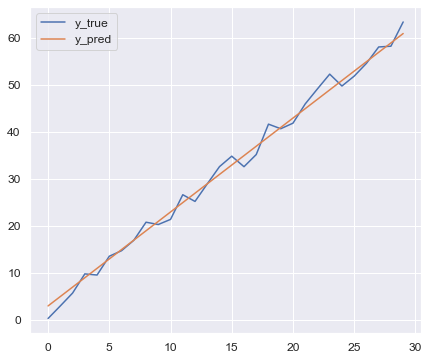

In [21]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [22]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 2.640555768317195
mse library: 2.640555768317195

mae custom : 1.3919911162604692
mae library: 1.3919911162604692

mape custom : 0.34395024497513843
mape library: 0.3439502449751384

r2 custom : 0.9917788563231421
r2 library: 0.9917788563231421

all tests passed


#### 0s in target. MAPE should explode

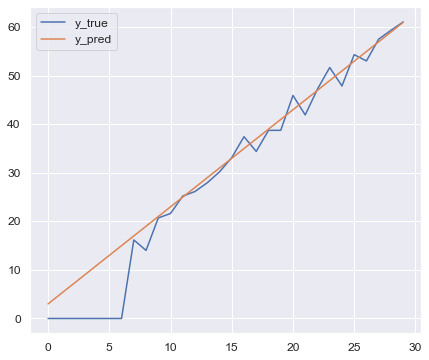

In [23]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_true[:7] = 0
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [24]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 25.592640388286977
mse library: 25.592640388286988

mae custom : 3.2460815675054437
mae library: 3.246081567505443

mape custom : 9457559217478042.0
mape library: 9457559217478042.0

r2 custom : 0.9379392992302987
r2 library: 0.9379392992302987

all tests passed


#### edge cases for R2

In [25]:
# constant target value

n = 30
x = np.arange(n)
y_true = np.repeat(15, n)
y_pred = 2 * x + 3

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 0
r2 library: 0.0

success


In [26]:
# perfect fit

n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = y_true

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 1
r2 library: 1.0

success


### Define helper functions

In [27]:
def get_metrics(*, y_true, y_pred) -> pd.Series:
    """ A helper function to return all metrics for given labels and predictions. """
    
    # if you didn't implement some metrics, comment them out for this function to work.
    return pd.Series({
        'mse': mse(y_true=y_true, y_pred=y_pred),
        'mae': mae(y_true=y_true, y_pred=y_pred),
        'mape': mape(y_true=y_true, y_pred=y_pred),
        'r2': r2(y_true=y_true, y_pred=y_pred),
    })

In [28]:
def fit_and_evaluate(model, x_train, y_train, x_test, y_test) -> pd.DataFrame:
    """ 
    A helper function to: 
    * fit a passed model
    * and return metrics on train and test sets.
    """
    # fit the model
    model.fit(x_train, y_train)
    
    # return metrics as pd.DataFrame
    m = pd.DataFrame([
        get_metrics(y_true=y_train, y_pred=model.predict(x_train)),  # metrics for train set
        get_metrics(y_true=y_test, y_pred=model.predict(x_test))     # metrics for test set
    ], index=['train', 'test']
    )
    
    return m

## train/test split

* Split the data we have into Train and Test splits with 80%/20% proportion

In [29]:
print(df.shape)
ix_split = int(0.8 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(8465, 35) (2117, 35)


In [30]:
def get_train_test_data(features: List[str], target: str) -> tuple:
    """
    Return x_train, y_train, x_test, y_test using 
    * global train/test split 
    * features and target provided.
    """
    # in general, it's a bad practice to use global variables. 
    # however, we use it here with caution for simplicity.
    return (
        DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), 
        DF_TEST[features].copy(), DF_TEST[target].copy()
    )

## Linear regression with 1 variable

* Let's start with Linear Regression that predicts target variable 
  using only 1 predictor (independent variable)  

* We will try to predict `dribbling` variable using `short_passing` as a predictor

In [31]:
target = 'dribbling'
features = ['short_passing']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's visualize our data first

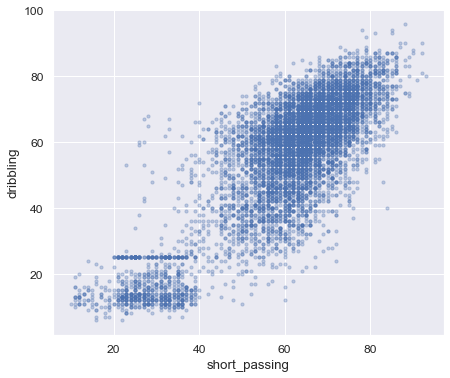

In [32]:
plt.scatter(x=x_train, y=y_train, alpha=0.3, s=10);
plt.xlabel('short_passing');
plt.ylabel('dribbling');

* do you notice anything interesting on this plot?
* if so, how can we use it later to generate more accurate predictions?

Наблюдается положительная линейная связь между признаками

### Task 4. Compute Pearson correlation coefficient between feature and target (1 pont)
Hint: you can use either `pd.Series.corr` method or `np.corrcoef` function

In [33]:
y_train.corr(x_train.squeeze())

0.8109909275166491

### Solve using `sklearn`

* we will use `LinearRegression` class from `sklearn` library 
  to fit a linear regression model and use it to generate prediction

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [36]:
model_intercept = model.intercept_
model_slope = model.coef_[0]
print(f'model_intercept: {model_intercept}')
print(f'model_slope: {model_slope}')

model_intercept: -6.7239485010088345
model_slope: 1.0400347630507065


* use fitted model to get predictions for test set

In [37]:
model_preds = model.predict(x_test)
model_preds

array([72.31869349, 61.91834586, 67.11851968, ..., 58.79824157,
       42.15768536, 63.99841539])

* explore model quality on test set.

In [38]:
print('model metrics on test set')
metrics_test_1 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_1

model metrics on test set


mse     102.233262
mae       7.941077
mape      0.168081
r2        0.635518
dtype: float64

In [39]:
y_test.mean()

62.96221067548417

* can you explain what those metic values mean?

***MSE*** - Средняя квадратичная ошибка.
Чувствительна к выбросам, так как разница между фактическими и предсказанными значениями возводится в квадрат. Необходимо стремиться к минимизации ошибки (значение 0 - идеальная модель). Метрика достаточно сложно интерпретируема, удобна при сравнении моделей.

***MAE*** - Cредняя абсолютная ошибка.
Меньше штрафует за большие отклонения по сравению с MSE. Метрика достаточно сложно интерпретируема, удобна при сравнении моделей.

***MAPE*** - Средняя абсолютная процентная ошибка. 
Показывает долю (или процент) ошибки от фактических значений. Плохо работает на малых значениях целевой переменой или в случае, когда значения целевой переменной равны нулю. Легко интерпретируема.

$ {R}^{2} $ - Коэффициент детерминации.
Коэффициент детерминации измеряет долю дисперсии, объясненную моделью, в общей дисперсии целевой переменной. Фактически, данная мера качества — это нормированная среднеквадратичная ошибка. Если она близка к единице, то модель хорошо объясняет данные. Может приобретать отрицательные значения. 

В данном примере получены неплохие метрики. Коэффициент детерминации составляет 63,55%. MAPE - 16.81%. Значения корня квадратного MSE (10.11)  и значение MAE (7.94) отличаются не слишком сильно, при этом они значительно ниже среднего значения по целевому признаку (62.96).


#### Task 5. Calculate predictions for test set manually (1 point)

Above we used `LinearRegression.predict()` method to obtain predictions. 
Now let's do it manually!

Recall Linear Regression formula:

* $ \hat{y} = w_0 + w_1 \cdot x, $ 

    where:
    * $w_0$ is an intercept
    * $w_1$ is a slope
    * $x$ is a predictor
    * $\hat{y}$ is a predicted variable
  

* use intercept and slope values from fitted LinearRegression model

In [40]:
# use `x_test` for calculations as is (it's a DataFrame with 1 column).
# do not convert it to Series or numpy array.

# your code here:
model_manual_preds = model_intercept + model_slope*x_test

In [41]:
assert isinstance(model_manual_preds, pd.DataFrame)

In [42]:
# ensure our manual predictions are the same as model generated
assert np.allclose(model_preds, model_manual_preds.iloc[:, 0].to_numpy())
print('success')

success


#### Task 6. Plot test data and predicted values (1 point)

* use `plt.scatter` function as in example above.
* first build scatter plot for test data
* then build scatter plot with model predictions
* add plot title, axis names and legend

Hints:
* use `alpha` parameter to control opacity and `s` parameter to control size of points.
  this will make plot more readable
* use `label` parameter to add label to each set of points added to scatter plot
* use different color for model predictions. control with parameter `color`

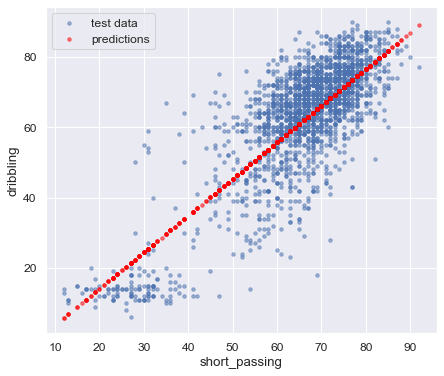

In [43]:
# # your code here
plt.scatter(x_test, y_test, label='test data', alpha=0.5, s=12)
plt.scatter(x_test, model_preds, color='red', label='predictions', alpha=0.5, s=12)
plt.legend();  # adds legend to a plot
plt.xlabel('short_passing');
plt.ylabel('dribbling');

### Task 7.  Fit regression model manually (3 points)

So far we have used `sklearn` library to fit linear regression model and obtain predictions. Good job!

Recall the formula of Linear regression for 1 variable:

* $ \hat{y} = w_0 + w_1 \cdot x $

Now let's try to fit the model **ourselves**.

### Theory

Assume our dataset consists of _n_ samples.

To fit a Linear regression model means to find the best set of parameters - 
$(w_0, w_1)$ that minimizes a **Loss function**.<br>
In case of Linear regression we choose **Residual sum of squares (RSS)** as a Loss function:

* $ L(w, x, y) = RSS(w, x, y) = \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

That is conceptually the same as minimizing Mean squared error (MSE):

* $ MSE(w, x, y) = \dfrac{1}{n} \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

Here:
* $y = (y_0, y_2, ..., y_{n-1}) $ - is a vector of target values we want to predict.
  1 value per each sample in our dataset that consists of _n_ samples
* $\hat{y} = (\hat{y}_0, \hat{y}_2, ..., \hat{y}_{n-1}) $ - is a vector of predictions 
* $\hat{y}_i = w_0 + w_1 \cdot x_i$ - is an individual prediction for _i_-th sample in a dataset

---

Best parameters $w_0$ and $w_1$ can be found using **following formulas**:

* $w_0 = \bar{y} - w_1 \cdot \bar{x}$


* $w_1 = \dfrac{\sum_{i=0}^{n-1}(x_i - \bar{x}) y_i}{\sum_{i=0}^{n-1}(x_i - \bar{x})^2}$


* where:
 * $\bar{x} = \dfrac{1}{n} \sum_{i=0}^{n-1}x_i$ - is the mean of vector $x$
 
 * $\bar{y} = \dfrac{1}{n} \sum_{i=0}^{n-1}y_i$ - is the mean of vector $y$
 
You should use these formulas to find the best model parameters in this task.
 
---

If you want to learn more you can refer to 
[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) wiki-page.

It contains analagous formula for $w_1$ coefficient that is conceptually the same 
(so it's not a bug in our formula provided above).

### Implementation

* convert pd.DataFrame and pd.Series (`x_train` and `y_train` respecitvely) to numpy-arrays

In [44]:
x = x_train.iloc[:, 0].to_numpy()
y = y_train.to_numpy()

* calculate model parameters ($w_1$ - slope and $w_0$ - intercept) using formulas given above

In [45]:
# # your code here:
x_hat = np.mean(x)
y_hat = np.mean(y)

manual_slope = ((x-x_hat)*y).sum()/((x-x_hat)**2).sum()
manual_intercept = y_hat-manual_slope*x_hat

In [46]:
print(f'manual_intercept: {manual_intercept}')
print(f'manual_slope: {manual_slope}')

manual_intercept: -6.723948501009076
manual_slope: 1.0400347630507105


In [47]:
assert round(model_intercept, 9) == round(manual_intercept, 9)
assert round(model_slope, 9) == round(manual_slope, 9)
print('success')

success


## Linear regression with multiple variables

* Now let's use Linear Regression model that uses multiple variables

* We will try to predict `dribbling` variable using 
  `['ball_control', 'short_passing', 'strength', 'sprint_speed']` features

In [48]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's explore the data first

In [49]:
cols = features + [target]
print(cols)

['ball_control', 'short_passing', 'strength', 'sprint_speed', 'dribbling']


#### Task 8 (1 point)

Build pairwise correlation matrix for selected features and target. Visualize it with heatmap.

Hints:
* use `DF_TRAIN` to build statistics (`x_train` contains only features. target is in `y_train`)
* use `pd.DataFrame.corr()` to build correlation matrix
* use `sns.heatmap` to build heatmap from correlation matrix. 
  * use `center` parameter to center your heatmap's colormap at 0
  * use diverging colormap (`cmap` parameter)<br>
    you can find the list of diverging colormaps
    [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging)<br>
    the reason is that we need to easily find both negative and positive correlations.
  * use `annot` parameters to add numbers to the plot.
* you can print `pd.DataFrame` and build plot in the same cell.<br> 
  use `display(...)` function that accets `pd.DataFrame` before building the plot
  
You can refer to [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) documentation

,ball_control,short_passing,strength,sprint_speed,dribbling
ball_control,1.000000,0.904768,-0.019510,0.559777,0.917877
short_passing,0.904768,1.000000,0.038186,0.442976,0.810991
strength,-0.019510,0.038186,1.000000,-0.204936,-0.147584
sprint_speed,0.559777,0.442976,-0.204936,1.000000,0.642627
dribbling,0.917877,0.810991,-0.147584,0.642627,1.000000


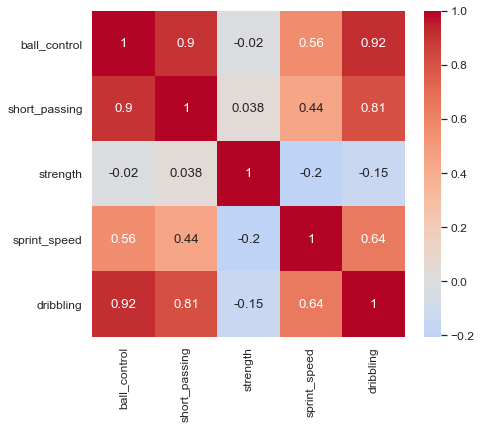

In [50]:
# # your code here

correlation_matrix = DF_TRAIN[cols].corr()
display(correlation_matrix)
sns.heatmap(correlation_matrix, center=0, cmap='coolwarm', annot=True);

* what can you say about selected feature set using this correlation matrix?

Наблюдается сильная положительная линейная связь между целевым признаком dribbling и независимыми признаками ball_control (0.92), short_passing (0.81) и sprint_speed (0.64). Также присутствует сильная связь между переменными ball_control и short_passing (0.91).

#### Let's build pairplots for features and target

* `plot_kws` parameter accepts dictionary of keyword arguments 
  that are passed to bivariate plotting function (`sns.scatterplot` in this case)


* we set size to 7 (using `s` parameter) to make points smaller and see patterns clearly.<br>
  you can compare this to running with not `plot_kws` passed.
  

* `alpha` parameter also helps to see data distribution clearly


* you can also experiment with `kind` parameter - refer to
  [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
  documentation for possible values.

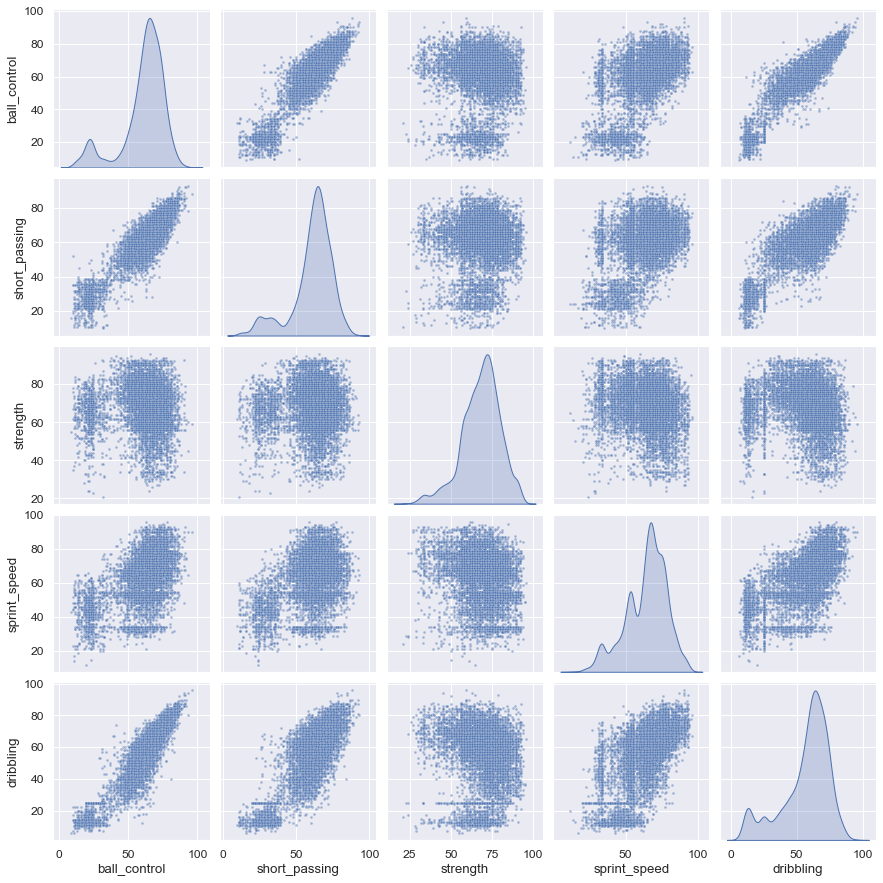

In [51]:
sns.pairplot(DF_TRAIN[cols], plot_kws={'s': 7, 'alpha': 0.5}, diag_kind='kde');

* what can you say about these scatterplots? is there anything we can use later?

В целом, зависимости соответствуют коррелляции. Например, для целевого признака и независимой переменно  ball_control видна сильная положительная линейная связь. Для признаков dribbling и strength взаимосвязь (если она есть) явно не носит линейного характера.

 ### Solve using `sklearn`

In [52]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [53]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: -3.992437572291969
model_coef: [ 0.97827644 -0.02816149 -0.15071567  0.20156021]


* how to interpret these model parameters?

In [54]:
x_train.columns

Index(['ball_control', 'short_passing', 'strength', 'sprint_speed'], dtype='object')

Наша модель имеет следующий вид:\
dribbling = -3.99243757 + 0.97827644 * ball_control - 0.02816149 * short_passing - 0.15071567 * strength + 0.20156021 * sprint_speed

* use fitted model to get predictions for test set

In [55]:
model_preds = model.predict(x_test)
model_preds

array([74.19050292, 71.97450231, 66.82691729, ..., 66.8384666 ,
       57.31145442, 51.96569027])

* explore model quality on test set.

In [56]:
print('model metrics on test set')
metrics_test_2 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_2

model metrics on test set


mse     30.677297
mae      3.873210
mape     0.087232
r2       0.890629
dtype: float64

* Let's compare `metrics_test_2` against `metrics_test_1`

In [57]:
# combine 2 series in 1 dataframe
metrics_comparison = metrics_test_1.to_frame('LR_1v').join(metrics_test_2.rename('LR_mv')).T
metrics_comparison

,mse,mae,mape,r2
LR_1v,102.233262,7.941077,0.168081,0.635518
LR_mv,30.677297,3.873210,0.087232,0.890629


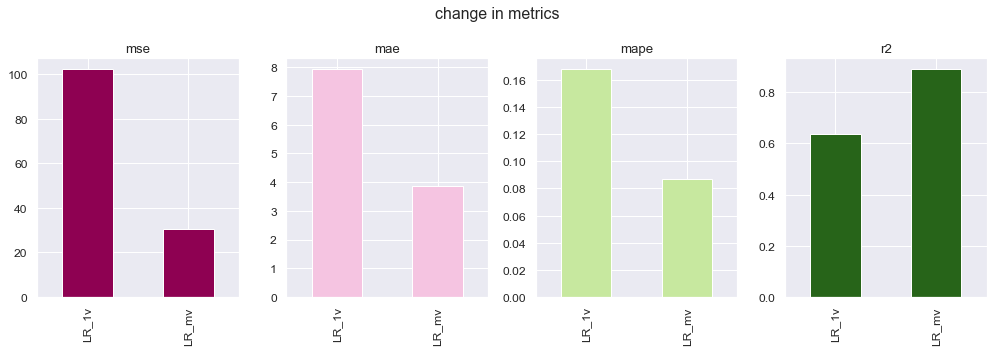

In [58]:
fig, ax = plt.subplots(figsize=(14, 5))  # specify figure size
metrics_comparison.plot(
    kind='bar', layout=(1,4), subplots=True, 
    title='change in metrics', legend=False, ax=ax, colormap='PiYG'
);
fig.tight_layout();  # prettify subplots. read more in documentation if interested

* did our Linear regression model improve after we've added more features?

Да, улучшение видно по всем изученным метрикам. Значения MSE, MAE и MAPE снизились. При этом коэффицинт детерминации вырос и с новой моделью мы можем объяснить 89,0% дисперсии целевой переменной.

### Task 9. Implement Linear regression model with multiple variables yourself (5 points)

Okay, we've fitted Linear regression model using `sklearn` library. Now let's do the math ourselves!

### Prerequisites

For this task you will need to:
* have basic understanding of Linear algebra (operations with vectors and matrices)
* know how to perform matrix multiplication, transposition and inversion using `numpy` 
  (these functions can be found in NumPy documentation)
* carefully read the theory below and refer to wiki / textbooks / other sources if required

---

### Theory and notation

When we extend Linear regression model on case with $m$ variables we get the following formula:

* $ \hat{y}
= 1 \cdot w_0 + x_1 \cdot w_1 + x_2 \cdot w_2 + ... + x_m \cdot w_m
= \sum_{i=0}^{m} x_i w_i
$,

where:
* $x = (1, x_1, ..., x_m)$ is an _(m+1)_-element feature vector. 
    * $x_0 = 1$ is a special term introduced in the beginning of feature vector 
      to add intercept to Linear regression model
    * $x_i, i=\overline{1,m}$ is an _i_-th feature value.
* $w = (w_0, w_1, ..., w_m)$ is an _(m+1)_-element parameter vector
    * $w_0$ - the first value of parameter vector - is referred to as **intercept**
* $\hat{y}$ is a predicted value

----

The formula above is used to calculate predictions for 1 sample.
i.e. we predict 1 scalar $\hat{y}$ from 1 feature vector $x$.

If we have a dataset of $n$ samples $(x, y)$ - we get a system of linear equations:

$
\begin{cases}
 \hat{y}^{(0)} = \sum_{i=0}^{m} x_i^{(0)} w_i \\
 \hat{y}^{(1)} = \sum_{i=0}^{m} x_i^{(1)} w_i \\
 ... \\\
 \hat{y}^{(n-1)} = \sum_{i=0}^{m} x_i^{(n-1)} w_i
\end{cases}
$

Such system can be rewritten in a succinct matrix form (a way that we write equations in Linear algebra):

* $ \hat{y} = X \cdot w $

And the task of minimizing Residual sum of squares (RSS) now looks:
* $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = \|y - X \cdot w \|_2^2 \rightarrow min $

Here:
* $y = (y^{(0)}, y^{(1)}, ..., y^{(n-1)})$ now denotes a **vector of target values** we want to predict<br>
  $y^{(j)}$ is a target value for _j_-th sample in a dataset.
* $\hat{y} = (\hat{y}^{(0)}, ..., \hat{y}^{(n-1)})$ 
  now denotes a **vector of predictions** <br>
  $\hat{y}^{(j)}$ denotes a predicted value for _j_-th sample in a dataset
* $X$ is a **feature matrix** of shape $n \times (m+1)$. <br>
  _n_ rows correspond to _n_ data samples and _m+1_ columns correspond to _m+1_ features that describe each sample.
* $w = (w_0, w_1, ..., w_m)$ is still a **model parameter vector**
* $X \cdot w$ denotes a **matrix-by-vector** multiplication
* $\|\cdot\|_2$ denotes an $L_2$-norm and is basically a square root of sum of squares of vector elements:<br>
  $\|a\|_2 = \sqrt{a_0^2 + a_1^2 + ... + a_{n-1}^2}$ for an _n_-component vector _a_.
  Thus, RSS means the same as before:<br>
  $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = 
  (y^{(0)} - \hat{y}^{(0)})^2 + (y^{(1)} - \hat{y}^{(1)})^2 + ... + (y^{(n-1)} - \hat{y}^{(n-1)})^2 = 
  \sum_{j=0}^{n-1} (y^{(j)} - \hat{y}^{(j)})^2
  $

Note:
* we now use **superscripts** $\hat{y}^{(i)}$ instead of **subscripts** $\hat{y}_i$ as before
  to denote _i_-th sample in a dataset
* it is done to be able to refer both to sample index (denoted by superscript)
  and feature index (denoted by subscript) in a single equation. 
  
  Thus:
  * $x^{(j)} = (1, x^{(j)}_1, x^{(j)}_2, ..., x^{(j)}_{m})$  now denotes 
    _j_-th feature vector in a dataset with _m+1_ features
  * $x_i^{(j)}$ denotes an _i_-th feature value of _j_-th feature vector
  * $X = 
  \begin{bmatrix}
      1 & x^{(0)}_1 & x^{(0)}_2 & ... & x^{(0)}_{m} \\
      1 & x^{(1)}_1 & x^{(1)}_2 & ... & x^{(1)}_{m} \\
      ... \\
      1 & x^{(n-1)}_1 & x^{(n-1)}_2 & ... & x^{(n-1)}_{m}
    \end{bmatrix}
    $ is an $n \times (m+1)$ feature matrix. <br><br>
    $X$ can also be written as a column-vector of feature vectors:<br><br>
    $ X = \begin{bmatrix}x^{(0)} \\ x^{(1)} \\ ... \\ x^{(n-1)}\end{bmatrix} $

---

### Fit 

**<TL;DR\>** Enough notation! How can we fit this model?

By minimizin Residual sum of squares (RSS) for a Linear regression equation in a matrix form
we now get a **single** formula to find **all model parameters**!
* $ w = (X^T X)^{-1} X^T y $

Beautiful, isn't it? <br>
Recall, how we got individual formulas for $w_0, w_1$ in case of Linear regression with 1 predictor.<br>
Now we can find the whole parameter vector _w_ at once!

In the formula above:
* $X$ is an $n \times (m+1)$ dimensional feature matrix


* $X^T$ is a **transposed** feature matrix.<br>
  Transposition is a mathematical operation of "swapping" matrix dimensions.<br>
  So $X^T$ is an $(m+1) \times n$ dimensional matrix  


* $ (X^T X)^{-1} $ is the inverse matrix of $ X^T X $

Notes:
* Because of inversion operation performed on $X^T X$ matrix 
  there are difficulties in fitting Linear regression model in some cases.
  
  We will talk more on that later in the assignment.

---
    
If you want to learn more you can refer to 
[Linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares)
wiki-page.

### Implementation

* implement `LRMatrixForm` class and `add_ones_column` function.<br>
  docstrings describe what each function/method should do - so read the docstrings.
  
  
* [what is a docstring?](https://www.python.org/dev/peps/pep-0257/#what-is-a-docstring)


Note:
* `LRMatrixForm` class must support 2 modes: **with** fitting intercept parameter and **without**.<br>
  The behavior is controlled by `fit_intercept` parameter passed to class constructor.

In [59]:
from sklearn.exceptions import NotFittedError

In [60]:

def add_ones_column(x):
    """ 
    Add column consisting of ones to the beginning of matrix `x`. 
    Used when fitting `LRMatrixForm` with `fit_intercept` param set to True.
    """
    # HINTS: 
    # * create a vector that consists of ones: (1, 1, ..., 1)
    # * then use either `np.column_stack` or `np.hstack` function to add this vector to a matrix
    
    # # your code here:
    return np.hstack((np.ones((x.shape[0], 1)), x))

class LRMatrixForm:
    """
    Class that encapsulates Linear regression model with multiplie variables.
    Calculations are performed using matrix formula.
    
    Use `fit()` method to fit the model on data.
    Use `predict()` method to calculate predictions when the model is fitted.
    """
    def __init__(self, fit_intercept: bool = True):
        """
        fit_intercept: 
        Whether to calculate the intercept for this model. 
        If set to False, no intercept will be used in calculations 
        (i.e. data is expected to be centered).
        """
        self.fit_intercept = fit_intercept
        self.w_ = None  # vector with all model parameters (intercept and weights)
    
    def fit(self, x_train: pd.DataFrame, y_train: pd.Series):
        X = x_train.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            # when creating a model with intercept term we need to extend feature matrix
            # with a column consisting of ones (1, 1, ..., 1).
            X = add_ones_column(X)
            
        # # your code here to calculate model parameters:
        y = y_train.to_numpy()
        self.w_ = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)
        
    @property
    def coef_(self):
        """ Property that returns model parameters without the intercept term. """
        if self.w_ is None:
            raise NotFittedError()
        # # your code here:
        if self.fit_intercept is True:
            return self.w_[1:]  # for compatibility with sklearn
        return self.w_
    
    @property
    def intercept_(self):
        """ Property that returns intercept term from model parameters. """
        if self.fit_intercept is not True:
            return 0.0  # for compatibility with sklearn
        if self.w_ is None:
            raise NotFittedError()
        # # your code here:
        return self.w_[0]
    
    def predict(self, x_test: pd.DataFrame):
        """ Generate predictions using fitted model parameters. """
        if self.w_ is None:
            raise NotFittedError()
        
        X = x_test.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            X = add_ones_column(X)
            
        # # your code here to calculate predictions
        return np.matmul(X, self.w_)

### Validate your implementation is identical to library version

In [61]:
lr_matrix_form = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,39.615760,4.567599,0.116144,0.875958
test,30.677297,3.873210,0.087232,0.890629


In [62]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: -3.992437572291093
coef: [ 0.97827644 -0.02816149 -0.15071567  0.20156021]


In [63]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values:

In [64]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean        0.146436
std         5.538081
min       -25.673668
25%        -3.101057
50%        -0.529283
75%         2.322094
max        30.957890
Name: dribbling, dtype: float64

### Now let's compare `sklearn` model and yours with `fit_intercept=False`

In [65]:
model = LinearRegression(fit_intercept=False)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,39.829119,4.598590,0.117298,0.875290
test,31.063199,3.954178,0.089012,0.889253


In [66]:
lr_matrix_form = LRMatrixForm(fit_intercept=False)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,39.829119,4.598590,0.117298,0.875290
test,31.063199,3.954178,0.089012,0.889253


* Compare the metrics on a test set of a model fitted **with** intercept parameter 
  vs model fitted **without** intercept.
* Which model has a better performance? Can you explain why?

In [67]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: 0.0
coef: [ 0.98901463 -0.04488432 -0.18226306  0.17943571]


In [68]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values again:

In [69]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean        0.078214
std         5.574205
min       -25.285351
25%        -3.205463
50%        -0.625120
75%         2.425520
max        30.677052
Name: dribbling, dtype: float64

* compare this to the same statistics obtained with model fitted **with intercept**
* notice how the _mean_ value of difference changed

In [70]:
model_int = LinearRegression(fit_intercept=True)
fit_and_evaluate(model_int, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,39.615760,4.567599,0.116144,0.875958
test,30.677297,3.873210,0.087232,0.890629


In [71]:
(model.predict(x_test) - y_test).describe().to_frame('without_intercept')\
        .join((model_int.predict(x_test) - y_test).describe().rename('with_intercept')).T

,count,mean,std,min,25%,50%,75%,max
without_intercept,2117.0,0.078214,5.574205,-25.285351,-3.205463,-0.625120,2.425520,30.677052
with_intercept,2117.0,0.146436,5.538081,-25.673668,-3.101057,-0.529283,2.322094,30.957890


In [72]:
from mlxtend.evaluate import bias_variance_decomp
model = LinearRegression(fit_intercept=False)
mse_without = pd.Series(bias_variance_decomp(model, x_train.to_numpy(),
                                 y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy(),
                                 loss='mse', num_rounds=200, random_seed=1)).to_frame('without_intercept').T


model_int = LinearRegression(fit_intercept=True)
mse_with = pd.Series(bias_variance_decomp(model_int, x_train.to_numpy(),
                                                y_train.to_numpy(), x_test.to_numpy(), 
                                                y_test.to_numpy(), loss='mse', num_rounds=200, random_seed=1)).to_frame('with_intercept').T
pd.concat([mse_without, mse_with]).rename(columns={0: 'mse', 1: 'bias', 2: 'variance'})


,mse,bias,variance
without_intercept,31.083465,31.066945,0.016520
with_intercept,30.705433,30.684135,0.021298


При введение интерцепта уменьшается смещение (bias), но увеличивается  дисперсия (разброс) (variance) оценки. В целом, метрики улучшаются при использовании интерцепта.

## Limitations of Linear regression

Recall the formula to find Linear regression parameters in case of multiple variables:
* $ w = (X^T X)^{-1} X^T y $

As noted above, there might be difficulties with fitting Linear regression model
because of inverting $X^T X$ matrix.

Not every matrix can be inverted.

An example of such case is when 2 or more features have strong linear relationship between them.<br>
It means that one of variables can be **linearly predicted from the others with a substantial degree of accuracy**.<br>
Such situation is named **collinearitry** (in case of 2 related variables)
or **multicollinearity** (>2 related features).<br>

Collinearity is associated with high value of correlation coefficient between 2 related features.

You can refer to [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) 
wiki page to read more.

The intuition why multicollinearity is bad is that Linear Regression tries to capture 
a contribution of each individual feature to target independently of other features.
This is not possible with the data that has collinear features, 
as change in one such variable is always associated with change in other/others.

There are a whole bunch of really interesting thoughts that can help you 
to capture the intuition behind the concept of multicollinearity.<br>
You can find some of them 
[here](https://stats.stackexchange.com/questions/1149/is-there-an-intuitive-explanation-why-multicollinearity-is-a-problem-in-linear-r).

### Collinearity

* Let's construct and add a new feature to our dataset that is going to be _collinear_ with another one:

In [73]:
# select features as usual
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

In [74]:
def add_collinear_column(_df: pd.DataFrame, orig_col: str, new_col: str):    
    """ 
    Construct new column as a linear transform of another one + tiny noise.
    y = f(x) = a1 * x + a2 + noise.
    
    Alternatively, we could apply no linear transform at all (set a1=1, a2=0)
    And only add some noise to existing column. Results would be the same.
    """
    # linear transform
    _df[new_col] = 2 * _df[orig_col] + 3
    # add tiny normal noise
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

orig_col = 'sprint_speed'
new_col = 'sprint_speed_2'
add_collinear_column(x_train, orig_col, new_col)
add_collinear_column(x_test, orig_col, new_col)
features.append(new_col)

In [75]:
corr_coef = np.corrcoef(x_train[orig_col], x_train[new_col])[0, 1]
print(f'correlation between {orig_col} and {new_col}: {corr_coef}')

correlation between sprint_speed and sprint_speed_2: 0.9999999999936928


* As expected, correlation coefficient between collinear features 
  (`sprint_speed` and `sprint_speed_2`) is close to 1.<br>
  Thus they are highly correlated.

In [76]:
# visualize sample of train data
check = x_train.sample(5).copy()
# add helper column to see how much noise was added
check['sprint_speed_2_wo_noise'] = 2 * check['sprint_speed'] + 3
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,sprint_speed_2_wo_noise
163750,73.0,60.0,90.0,67.0,137.000083,137.0
133484,77.0,75.0,64.0,80.0,163.000006,163.0
147814,74.0,76.0,84.0,68.0,138.999989,139.0
18448,59.0,48.0,78.0,62.0,126.999895,127.0
13461,77.0,68.0,82.0,76.0,154.999947,155.0


### let's fit a Linear Regression model on this feature set:

In [77]:
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,39.594523,4.567489,0.116162,0.876025
test,30.697432,3.871444,0.087164,0.890557


* Both train and test metrics look reasonable
* Now let's explore model params:

In [78]:
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

intercept: 4391.542435155683
coef: [0.9784899731691789, -0.02823509335404302, -0.15071666170484543, 2930.5617688408315, -1465.1801456630844]


* Weights that correspond to `sprint_speed` and `sprint_speed_2` columns should have gone insanely high!


* That is not ok. Large weights and weights instability are the sign of 
    [**overfitting**](https://en.wikipedia.org/wiki/Overfitting).

    According to the definition, overfitting is:<br>
    "_the production of an analysis that corresponds too closely 
    or exactly to a particular set of data,<br>
    and may therefore fail to fit additional data 
    or predict future observations reliably_".
    
    
* But what does that mean? Let's try to generate predictions with our model.

### generate predictions using our fitted model

In [79]:
check = x_test.head(2).copy()
check[target] = y_test.head(2)
check['preds'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds
174915,76.0,76.0,62.0,76.0,155.000118,75.0,74.01613
46447,70.0,66.0,53.0,86.0,175.000061,71.0,71.88295


In [80]:
get_metrics(y_true=check[target], y_pred=check['preds'])

mse     0.873801
mae     0.933410
mape    0.012777
r2      0.781550
dtype: float64

* predictions look good, right? 

### but what if we change `sprint_speed` values a bit? let's add some small `delta`

In [81]:
delta = 1  # some small value
check['sprint_speed'] += delta
check['preds_2'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds,preds_2
174915,76.0,76.0,62.0,77.0,155.000118,75.0,74.01613,3004.577899
46447,70.0,66.0,53.0,87.0,175.000061,71.0,71.88295,3002.444719


In [82]:
get_metrics(y_true=check[target], y_pred=check['preds_2'])

mse     8.587897e+06
mae     2.930511e+03
mape    4.017450e+01
r2     -2.146973e+06
dtype: float64

* Wow, new predictions doesn't look even close to the target!<br>
  Our model doesn't look like a good model anymore.
  

* That is exactly what overfitting is. <br>
  **We fail to obtain reasonable predictions when we apply our model on new data**.

### One might notice that we have changed only 1 of 2 collinear features
* Indeed, giant model weights that correspond to these 2 features, should cancel each one out<br>
  if relation between feature values stays the same.  

* Let's check this out.<br>
  We have performed following transform:<br>
  `sprint_speed_changed = sprint_speed + delta`<br>
  

* How should we change `sprint_speed_2` to match the same data distribution from train data?<br>
  
  Let's calculate (we will ignore the noise added):  
  `sprint_speed_2_changed - sprint_speed_2 = f(sprint_speed_changed) - f(sprint_speed) =`<br>
  `= a1 * sprint_speed_changed + a2 - (a1 * sprint_speed + a2) = a1 * delta`

In [83]:
# here we change the second of collinear features 
# using the same coefficient 
# that was used in linear transform in `add_collinear_column()` function.
# we don't need to add intercept coefficient as it cancels it out (you can do the math yourself).
check['sprint_speed_2'] += 2 * delta
check['preds_3'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds,preds_2,preds_3
174915,76.0,76.0,62.0,77.0,157.000118,75.0,74.01613,3004.577899,74.217608
46447,70.0,66.0,53.0,87.0,177.000061,71.0,71.88295,3002.444719,72.084428


* In the last example we see that new predictions (`preds_3`) now look similar to the first ones <br>
  (`preds` - calculated before changing `sprint_speed` value)


* So, if values of collinear features change accordingly - we are safe, right? <br>
  How do your think, can we always rely on this assumtion?

Нет, так как наша модель теряет усточивость и ее предсказательная сила на новых данных падает.

### What just happened

* The answer to the question above is: **no, we can't**.
  
  
* Yes, we have checked that if collinear features values are changed accordingly 
  (i.e. their **initial relation is preserved**), <br>
  model predictions look reasonable and accurate.
  
  But this will not always be the case on the real data.
  
  We can't be sure that the data 
  that we apply our fitted model on (`x_test`, for example)<br>
  preserves **exactly the same data distribution** as the data that model was trained on (`x_train`).
  
  

**Why this happened?**

* When feature matrix contains collinear or multicollinear features (the problem of **multicollinearity**),
  inversion of such a matrix is numerically unstable.<br>
  This leads to large values and imprecise estimates of model parameters.

**How to detect multicollinearity**
* You should monitor your model weights. For example using $L_2$ norm:<br>
  $ L_2(w) = \|w\|_2 = \sqrt{w_1^2 + w_2^2 + ... + w_n^2} = \sqrt{\sum_{i=1}^{n} w_i^2} $<br>
  If any of model weights are huge - $L_2$ norm will also have large value.
  
  
* Monitor model performance on validation data. 
  If the metrics are poor and prediction look huge,<br>
  you should check if collinear features are present in train data.

**How to fix the issue**

* For each set of collinear features, keep only 1 of them and remove the rest.<br>
  The best regression models are those in which the predictor variables each correlate highly 
  with the target variable,<br>
  but correlate at most only minimally with each other.
  

* Combine collinear features into new ones

  
* Use regularization (will be covered later in the course).

### Task 10. Implement function to calculate $L_2$-norm. (1 point)
* Use formula above to implement $L_2$ norm

In [84]:
def l2_norm(arr: Iterable):
    # sum(model.coef_**2)**0.5
    return np.linalg.norm(arr)

### Calculate $L_2$-norm value for current model
* you should get high value that represents large values of some model parameters

In [85]:
l2_norm(model.coef_)

3276.4227628912845

### Multicollinearity
  
* It's important to notice that in case of multicollinearity,
  correlation coefficient between each pair of related variables
  could be **not so high**.
  
  So **it may be hard to find multicollinear features in your data**.
  

* Let's visualize it in practice.

  We will build a new feature that has a strong linear relationship with 2 other features:
  $x_1 = a_0 + a_2 x_2 + a_3 x_3 + noise$

  We want to show that Linear regression model will still suffer from multicollinearity,<br>
  but correlation coefficients betweent each pair of multicollinear features will be **less close to 1**
  than it was in case of collinearity.

In [86]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

def add_collinear_column(_df: pd.DataFrame, col1: str, col2: str, new_col: str):    
    _df[new_col] = _df[col1] + _df[col2] + 5
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

add_collinear_column(x_train, col1='sprint_speed', col2='strength', new_col='foo')
add_collinear_column(x_test, col1='sprint_speed', col2='strength', new_col='foo')
features.append(new_col)

model = LinearRegression(fit_intercept=True)
m = fit_and_evaluate(model, x_train, y_train, x_test, y_test)
display(m)
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

,mse,mae,mape,r2
train,39.612308,4.567592,0.116141,0.875969
test,30.706928,3.874506,0.087261,0.890524


intercept: -2989.7463604026857
coef: [0.9782829218440645, -0.028134651475565355, -597.302179391683, -596.9498409805399, 597.1513998608175]


* As before, model parameters for multicollinear features should be large

* Let's calculate $L_2$-norm value - it should also be large

In [87]:
l2_norm(model.coef_)

1034.2677401608898

#### Task 11. Visualize correlation matrix for `x_train`  (1 point)
* Build annotated heatmap (use `annot` param to add values to plot, select diverging `cmap` and center it at 0)
* You should see that `foo` feature is correlated with ones it was created from,<br>
  but each of these correlation coefficients **is not so close to 1**

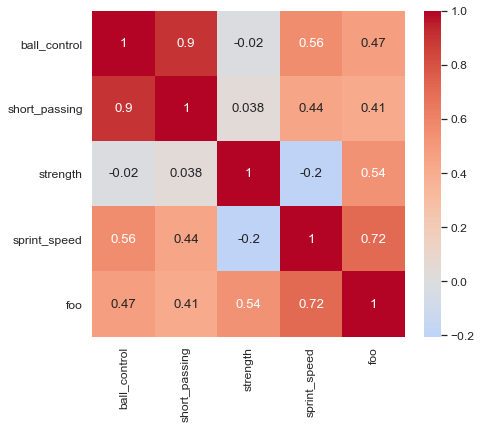

In [88]:
# your code here
sns.heatmap(x_train.corr(), center=0, cmap='coolwarm', annot=True);

### Regularization

* The concept of regularization (that was mentioned above) is simple.

  We modify Loss function (RSS in case of Linear regression) in such a way<br>
  to penalize for large values of model parameters.
  
  
* $L_2$ regularization, also named as 
  [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization), 
  adds $L_2$ term to loss function:

  $L(w,x,y) = RSS(w,y) + \alpha L_2(w) = \|y - \hat{y}\|_2^2 + \alpha \|w\|_2^2 
  = \|y - X \cdot w \|_2^2 + \alpha \|w\|_2^2$
  
  parameter $ \alpha \ge 0 $ controls the ammount of regularization applied
  

* Linear regression implemented with $L_2$ regularization is named a **Ridge regression**.


* Ridge regression is implemented in `Ridge` class in `sklearn` library

---

Let's see how applying regularization changes our model.

In [89]:
from sklearn.linear_model import Ridge

* at first fit `Ridge` without any regularization to ensure we get similar results 
  to using `LinearRegression`

In [90]:
# `solver` parameters determines the algorithm used to solve regression task.
# we fix it to be `svd` to achieve desired results.
model_r = Ridge(alpha=0, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,39.612308,4.567592,0.116141,0.875969
test,30.706928,3.874506,0.087261,0.890524


In [91]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: -2989.746360402668
coef: [0.9782829218440652, -0.028134651475533488, -597.3021793916828, -596.9498409805396, 597.1513998608172]
l2 norm: 1034.2677401608894


* some model parameters should be large, as well as the $L_2$-norm value
* now, let's add some regularization

In [92]:
model_r = Ridge(alpha=0.01, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,39.615741,4.567598,0.116144,0.875958
test,30.677368,3.873214,0.087232,0.890629


In [93]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: -12.210204504648523
coef: [0.9782764149020683, -0.02816138707263685, -1.7942704645655887, -1.4419944099910276, 1.6435546401344576]
l2 norm: 2.9929657601183464


* notice how parameter values changed
* also notice how $L_2$-norm values decreased

## Task 12. Putting all together. (up to 10 points)

In the final task we'll try to recap all that we have learnt so far.

Your task is to build a Linear regression model with multiple variables to predict `agility` variable.<br>
Only `LinearRegression` class is allowed to be used for modeling.<br>

Steps you need to follow:

* Make a new train/test split with new proportion: 70% on train and 30% on test data **(1 point)**


* Fit a model **(up to 6 points)**
    
    * Choose >= 10 features from training set as initial set of features
      Explain your choice. **(1 point)**
      
    * Visualize correlation matrix for selected features **(1 point)**
    
    * Analyze if collinear/multicollinear features are present in your feature set.<br>
      Process collinear/multicollinear features if they are present:<br>
      remove redundant features, combine features into new ones, etc **(up to 3 points)**
     
    * Fit the model and calculate metrics on train and test sets<br>
      **(1 point max. -0.25 points per each metric that was not implemented in the beginning of the assignment)**
    

* Analyze fitted model performance **(up to 2 points)**:
    * Print fitted model parameters and calculate their $L_2$-norm value **(1 point)**
    * Make conclusion whether your model overfitted or not. Provide your arguments. **(1 point)**


* Write a short report about the work done **(1 point)**<br>
  Can you find a logical explanation for high correlation of some of your features?<br>
  Are you satisfied with the quality of predictions?<br>
  How could you pottentially improve the model?<br>
  Any other thoughts.


**Penalties:**
- **0 points are assigned for the whole task** if used a model different from:
    - `sklearn.linear_model.LinearRegression`
    - or `LRMatrixForm`

* Make a new train/test split with new proportion: 70% on train and 30% on test data **(1 point)** 

Можно использовать предыдущий подход с индексом, но для разнообразия я воспользуюсь методом .sample(), что в дальнейшем позволит легко сгенерировать еще несколько выборок для проверки модели за счет изменения атрибута random_state. А также позднее изменю функцию get_train_test_data, чтобы в дальнейшем было проще модифицировать данные. 

In [94]:
# ix_split = int(0.7 * df.shape[0])
# DF_TRAIN = df.iloc[:ix_split].copy()
# DF_TEST = df.iloc[ix_split:].copy()
# print(DF_TRAIN.shape, DF_TEST.shape)

In [95]:
def df_split(df=df, random_state=200, frac=0.7):
    DF_TRAIN=df.sample(frac=frac, random_state=random_state)
    DF_TEST=df.drop(DF_TRAIN.index)
    return DF_TRAIN, DF_TEST

In [96]:
DF_TRAIN, DF_TEST = df_split()
print(DF_TRAIN.shape, DF_TEST.shape)

(7407, 35) (3175, 35)


In [97]:
target = 'agility'
features = df.columns[df.columns != target]
x_train, y_train, x_test, y_test = DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), DF_TEST[features].copy(), DF_TEST[target].copy()

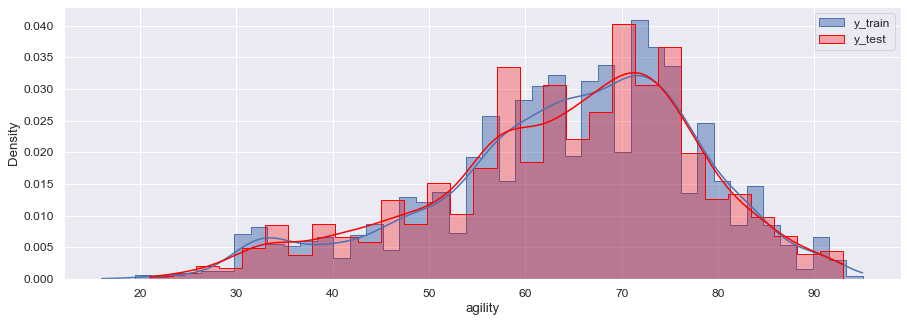

In [98]:
plt.figure(figsize=(15, 5))
sns.histplot(y_train, label='y_train', alpha=0.5, element="step", kde=True, stat='density')
sns.histplot(y_test, color='red', label='y_test', alpha=0.3, element="step", kde=True, stat='density')
plt.legend();

Хотя частота значений целевой переменной в обучающей выборке отличается от частоты в тестовой выборке, формы распределения близки, что позволяет использовать это train-test split для обучения модели.

* Fit a model **(up to 6 points)**
    
    * Choose >= 10 features from training set as initial set of features
      Explain your choice. **(1 point)** 
      
    * Visualize correlation matrix for selected features **(1 point)**
    
    * Analyze if collinear/multicollinear features are present in your feature set.<br>
      Process collinear/multicollinear features if they are present:<br>
      remove redundant features, combine features into new ones, etc **(up to 3 points)**
     
    * Fit the model and calculate metrics on train and test sets<br>
      **(1 point max. -0.25 points per each metric that was not implemented in the beginning of the assignment)**
    


Так как можно выбрать 10 или более независимых переменных, для начального анализа возьмем все доступные, за исключением ранее удаленных признаков. Исследуем их распределения и взаимосвязь с целевой переменной.

In [99]:
DF_TRAIN.describe()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000,7407.000000
mean,68.086675,71.055893,54.038207,48.250439,56.735925,61.926556,47.941542,57.977454,51.920886,48.210477,56.289186,62.248414,64.870258,65.151208,64.251789,65.578237,63.858647,61.031052,66.466856,64.503173,68.161334,52.112461,60.842311,50.536385,53.009316,56.314297,53.127987,46.977589,50.437289,47.965978,15.668152,15.328338,15.159579,15.497772,15.718645
std,6.290350,6.164336,17.590199,19.035601,16.859163,13.855081,18.006936,17.839660,18.295086,17.780949,14.533462,15.468666,14.170246,13.912746,13.788590,8.326500,13.519667,16.446793,11.314398,14.460697,11.535444,18.476183,16.395842,20.088791,19.074531,14.626608,15.919570,21.732484,21.914555,21.848425,17.161645,16.126682,15.628179,16.559705,17.507460
min,47.000000,51.000000,6.000000,5.000000,7.000000,11.000000,5.000000,6.000000,6.000000,6.000000,10.000000,9.000000,13.000000,13.000000,16.000000,24.000000,12.000000,6.000000,21.000000,10.000000,21.000000,6.000000,11.000000,6.000000,3.000000,3.000000,7.000000,4.000000,6.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,64.000000,67.000000,44.000000,33.000000,50.000000,58.000000,34.000000,51.000000,40.000000,35.000000,49.000000,58.000000,55.000000,55.000000,57.000000,60.000000,56.000000,54.000000,60.000000,58.000000,61.000000,40.000000,51.000000,31.000000,41.000000,48.000000,43.000000,25.000000,29.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,68.000000,71.000000,58.000000,51.000000,60.000000,65.000000,51.000000,62.000000,55.000000,49.000000,59.000000,66.000000,67.000000,68.000000,66.000000,66.000000,65.000000,65.000000,67.000000,67.000000,69.000000,57.000000,64.000000,56.000000,58.000000,58.000000,55.000000,53.000000,58.000000,55.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,72.000000,75.000000,67.000000,64.000000,68.000000,71.000000,62.000000,70.000000,66.000000,62.000000,66.000000,72.000000,75.000000,75.000000,74.000000,71.000000,73.000000,72.000000,74.000000,74.000000,76.000000,66.000000,73.000000,67.000000,67.000000,67.000000,65.000000,66.000000,69.000000,67.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,90.000000,93.000000,92.000000,90.000000,95.000000,93.000000,91.000000,94.000000,94.000000,94.000000,91.000000,93.000000,97.000000,96.000000,95.000000,91.000000,96.000000,94.000000,94.000000,95.000000,96.000000,91.000000,94.000000,93.000000,94.000000,94.000000,96.000000,90.000000,91.000000,95.000000,88.000000,87.000000,91.000000,90.000000,90.000000


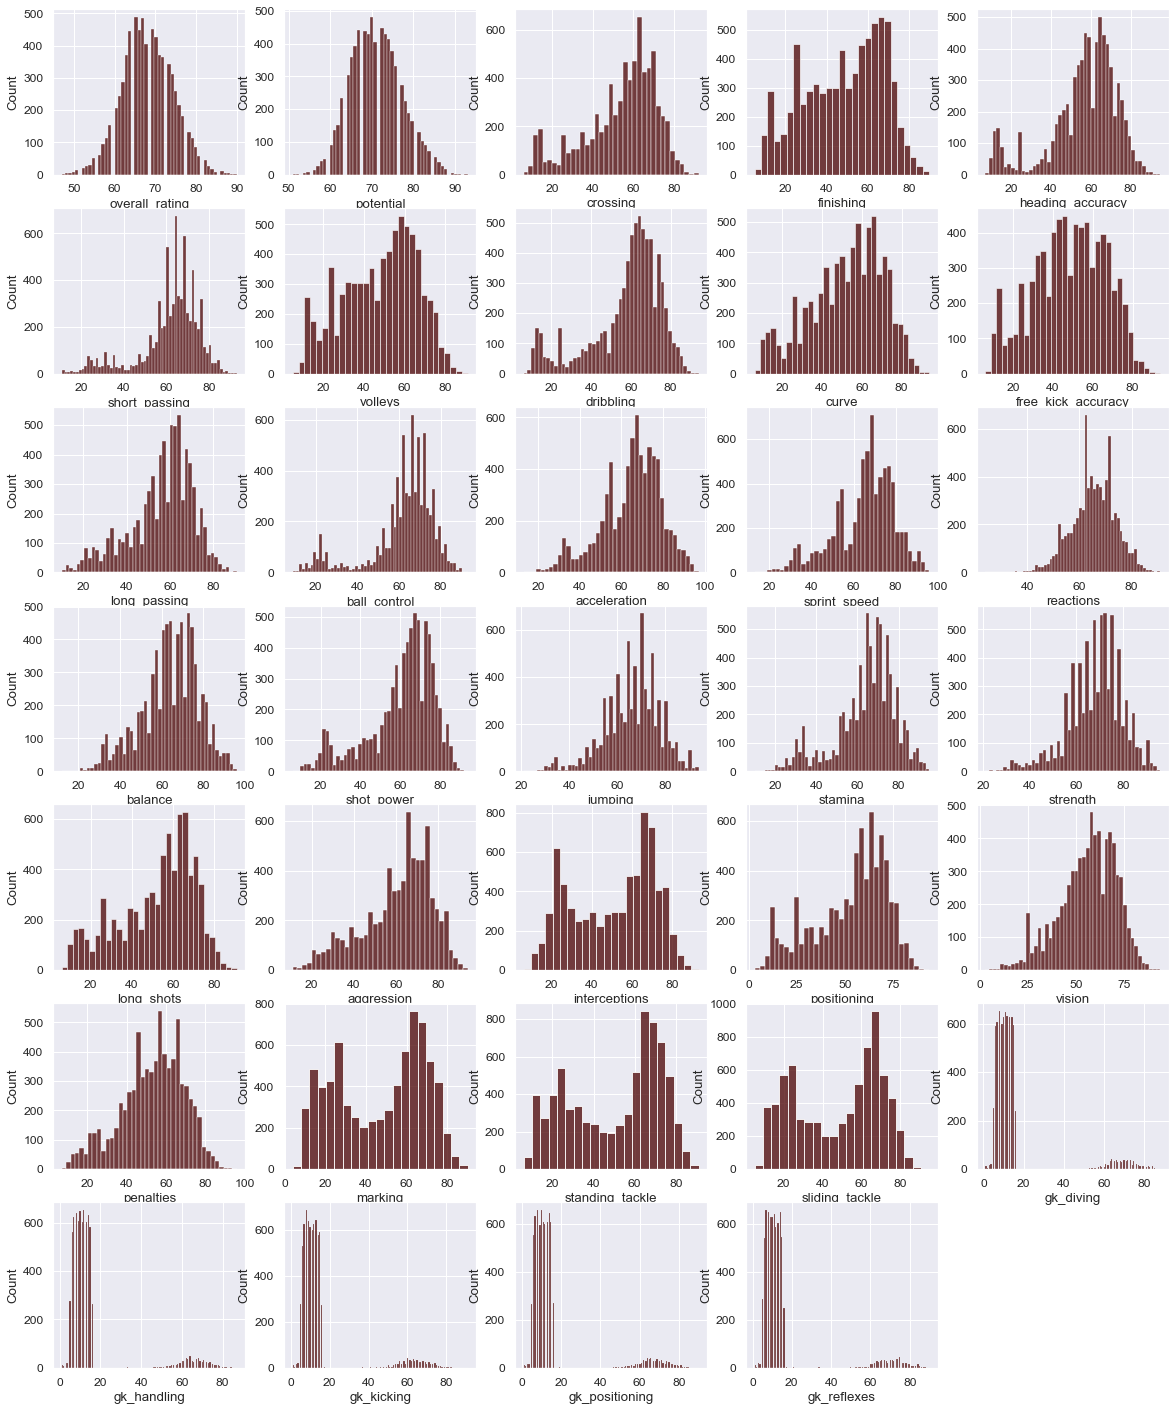

In [100]:
plt.figure(figsize=(20, 25))

for i, column in enumerate(x_train.columns, 1):
    plt.subplot(7,5,i)
    sns.histplot(DF_TRAIN[column], color=sns.color_palette('afmhot')[0]);

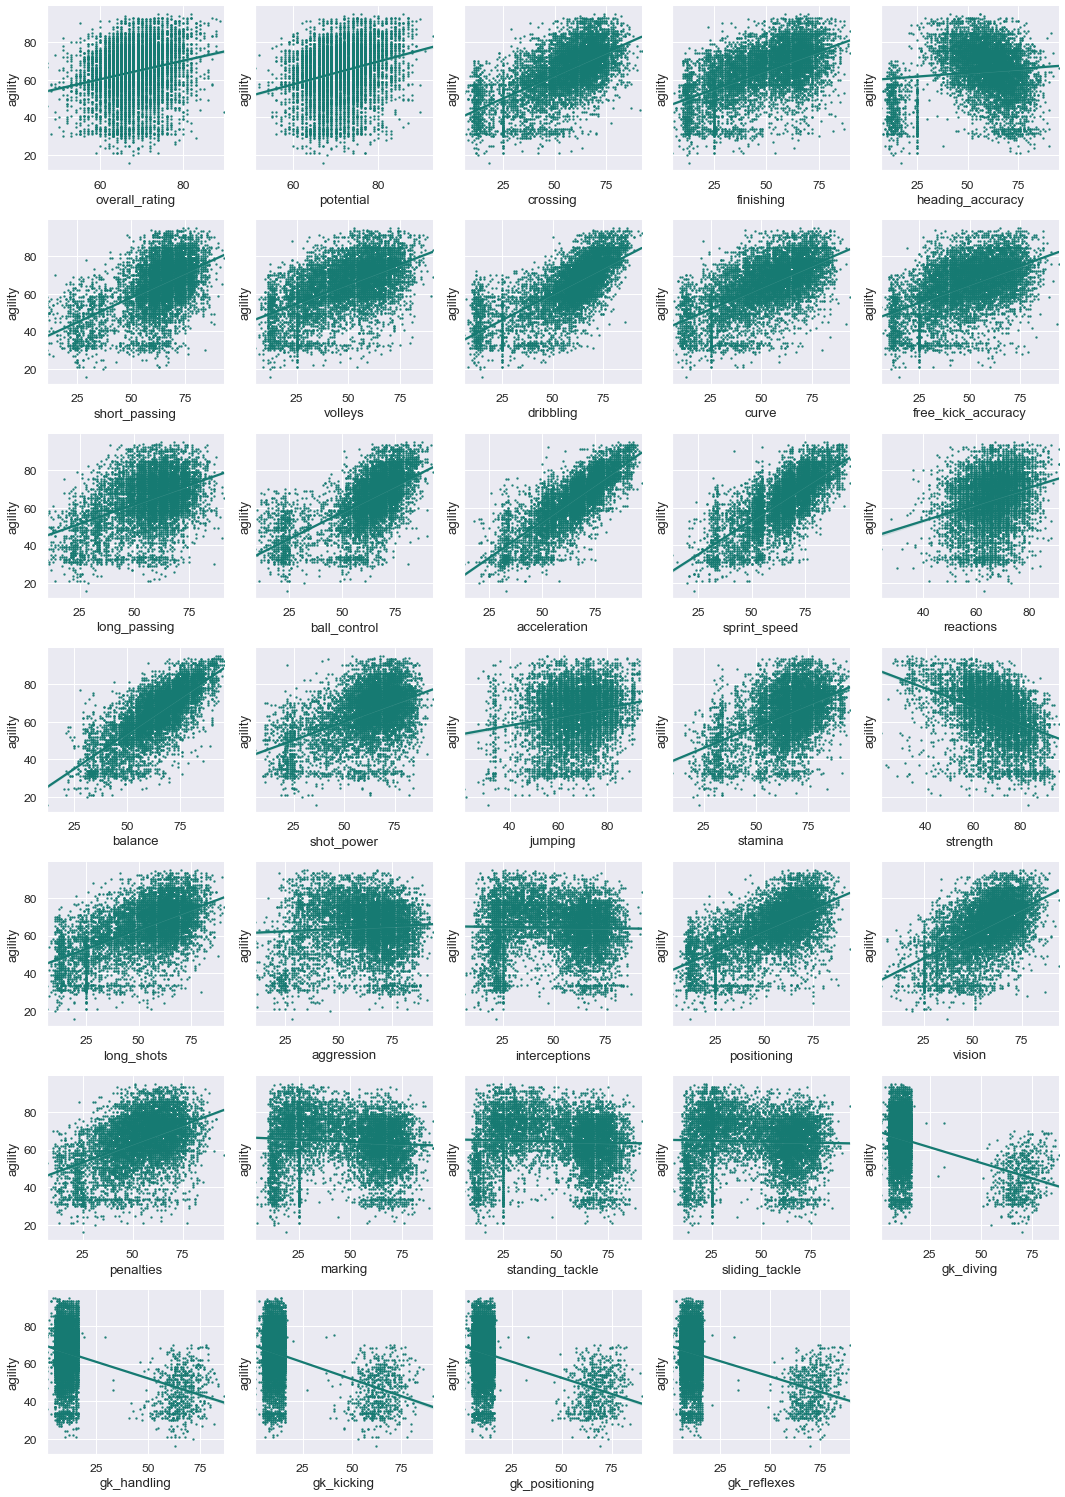

In [101]:
g = sns.FacetGrid(pd.DataFrame(x_train.columns), col=0, col_wrap=5, sharex=False)
for ax, x_var in zip(g.axes, x_train.columns):
    sns.regplot(data=DF_TRAIN, x=x_var, y="agility", ax=ax, color=sns.color_palette('BrBG_r')[0], scatter_kws={'s':2}, ci=90)
g.tight_layout()

Заметно, что распределения признаков, а также их связь с целевой переменной носят различный характер, однако наблюдается несколько паттернов. После изучения данной темы в открытых интеренет-источниках, выяснила, что все переменные можно сгруппировать в определенные кластеры. Кроме того, переменные overall_rating и potential явялются синтетическими составными переменными, являющимися суммой значений остальных переменных с определенными коэффициентами, плюс для переменной overall_rating учитиваются рейтинги, не входящие в данный датасет. 

Сгруппируем переменные по категориями и проанализируем корреляции внутри групп и с целевой переменной.

In [102]:
rating_cols = ['overall_rating', 'potential']
attacking_cols = ['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys']
cross_cols = ['dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control']
#include target feature
movement_cols = ['acceleration','sprint_speed', 'reactions', 'balance'] #'agility', 
power_cols = ['shot_power', 'jumping', 'stamina', 'strength', 'long_shots']
mentality_cols = ['aggression', 'interceptions', 'positioning', 'vision', 'penalties']
defending_cols = ['marking', 'standing_tackle', 'sliding_tackle',]
goalkeeping_cols = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
group_feat = [rating_cols, attacking_cols, cross_cols, movement_cols, power_cols, mentality_cols, defending_cols, goalkeeping_cols]
group_feat_name = ['rating', 'attacking', 'cross', 'movement', 'power', 'mentality', 'defending', 'goalkeeping']

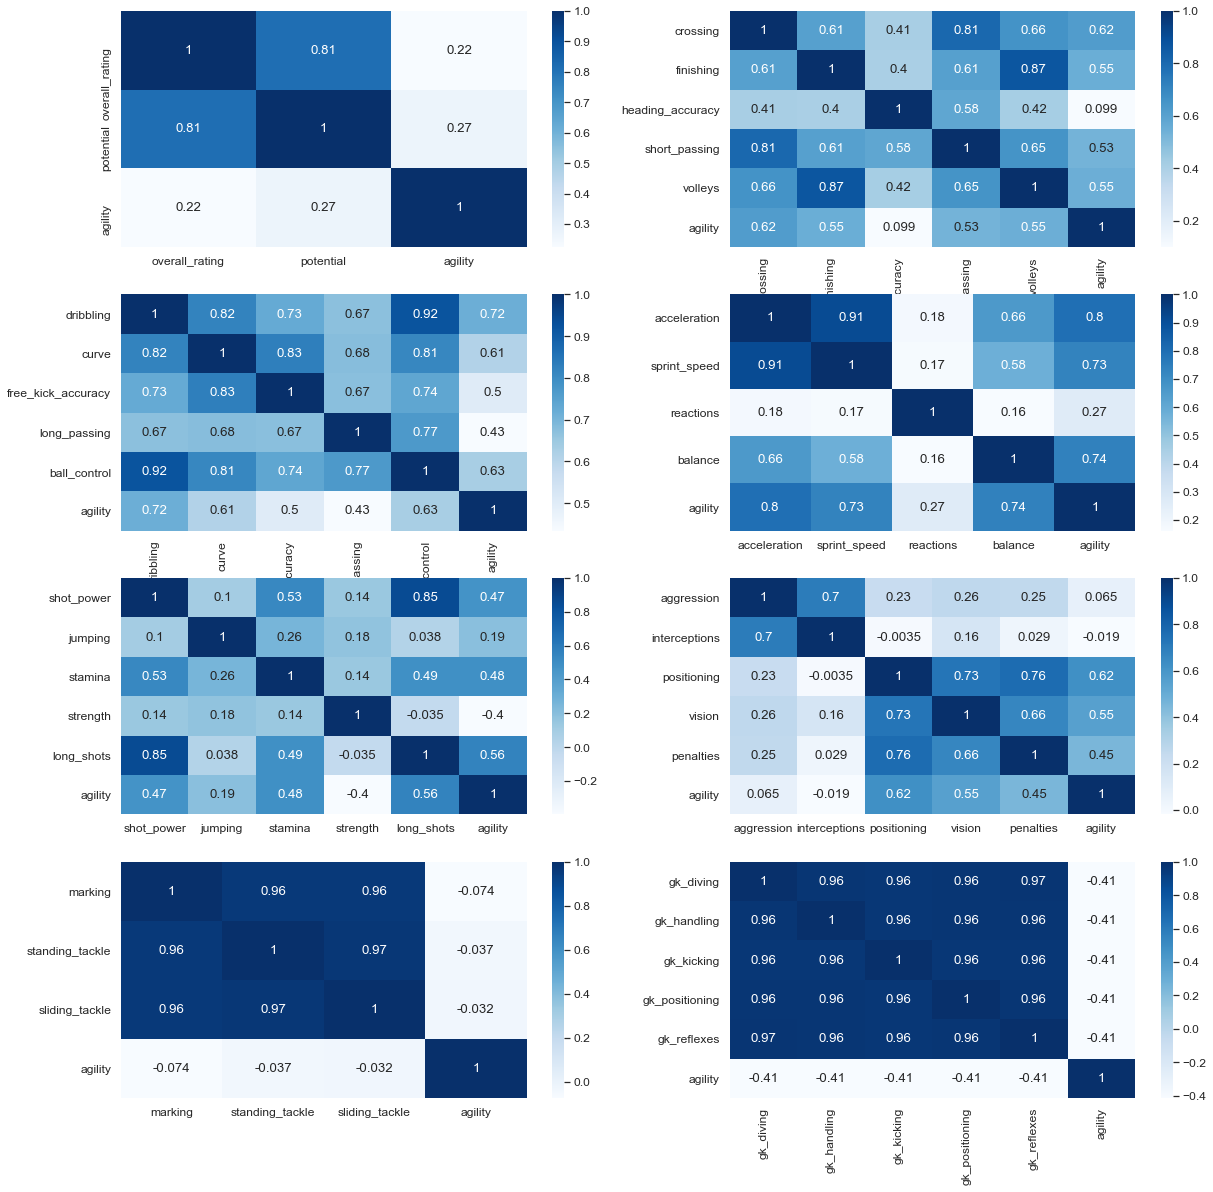

In [103]:
plt.figure(figsize=(20, 20))

for i, column in enumerate(group_feat, 1):
    plt.subplot(4,2,i)
    sns.heatmap(DF_TRAIN.loc[:, np.append(column, ['agility'])].corr(), annot=True, cmap=plt.cm.Blues, fmt='.2g') 

In [104]:
abs(DF_TRAIN.corr()['agility']).sort_values(ascending=False)[1:8]

acceleration    0.796623
balance         0.740781
sprint_speed    0.732764
dribbling       0.716838
ball_control    0.628804
crossing        0.623095
positioning     0.622697
Name: agility, dtype: float64

In [105]:
DF_TRAIN.corr()['acceleration'][['balance', 'sprint_speed', 'dribbling', 'ball_control',
       'crossing', 'positioning']]

balance         0.656633
sprint_speed    0.912387
dribbling       0.689514
ball_control    0.590591
crossing        0.581120
positioning     0.571240
Name: acceleration, dtype: float64

Максимальная корреляция для целевой переменной показана с переменной acceleration - 0.80, также высокие значения установленны для признаков balance, sprint_speed, dribbling (0.74, 0.73 и 0.72, соответственно). Однако, некоторые из этих признаков могут быть взаимозависимы, например корреляция между признаком acceleration и sprint_speed составляет 0.91.

Также, очевидно, что признаки в последних двух группах defending_cols и goalkeeping_cols находятся в очень сильной взаимосвязи между собой, это также легко прослеживается по графикам респределения параметров из этих групп. При этом признаки из группы goalkeeping_cols отличаются сильно скошенным вправо распределением.

Так как признаки имеют одинаковую связь с целевой переменной и между собой, создадим новые переменные, которые будут являться средними значениями по всем признакам группы для defending_cols и goalkeeping_cols. Предварительно скалируем переменные.

In [106]:
def reduce_corr_feat(DF_TRAIN=DF_TRAIN, DF_TEST= DF_TEST, goalkeeping_cols=goalkeeping_cols, defending_cols=defending_cols):
    scaler = StandardScaler()

    cols = DF_TRAIN.columns[DF_TRAIN.columns!='agility']
    train_ind = DF_TRAIN.index
    test_ind = DF_TEST.index
    scaled_train = scaler.fit_transform(DF_TRAIN.loc[:, cols])
    scaled_train = pd.DataFrame(scaled_train, columns=cols, index=train_ind)
    scaled_test = scaler.transform(DF_TEST.loc[:, cols])
    scaled_test = pd.DataFrame(scaled_test, columns=cols, index=test_ind)
    
    scaled_train.loc[:, 'goalkeeping'] = scaled_train[goalkeeping_cols].mean(axis=1)
    scaled_test.loc[:, 'goalkeeping'] = scaled_test[goalkeeping_cols].mean(axis=1)
    scaled_train.loc[:, 'defending'] = scaled_train[defending_cols].mean(axis=1)
    scaled_test.loc[:, 'defending'] = scaled_test[defending_cols].mean(axis=1)
    scaled_train = scaled_train.drop(goalkeeping_cols+defending_cols, axis=1)
    scaled_test = scaled_test.drop(goalkeeping_cols+defending_cols, axis=1)
    scaled_train.loc[:, 'agility'] = DF_TRAIN.loc[:, 'agility']
    scaled_test.loc[:, 'agility'] = DF_TEST.loc[:, 'agility']
    return scaled_train, scaled_test

Для уверенности, что метрики будут достоверными, необходимо проводить анализ в нескольких повторениях. Одиночное разбиение на обучающую и тестовую выборку может привести к смещению метрик как в положительную так и отрицательную стороны. Для уменьшения этого смещения сделаем несколько вспомогательных функций и будем строить модели для 10 разбиений и брать среднюю оценку.

In [107]:
def split_repeat(df=df, random_state=200, target=target):
    DF_TRAIN, DF_TEST = df_split(df=df, random_state=random_state) 
    DF_TRAIN, DF_TEST = reduce_corr_feat(DF_TRAIN, DF_TEST)
    features = DF_TRAIN.columns[DF_TRAIN.columns != target]
    x_train, y_train, x_test, y_test = DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), DF_TEST[features].copy(), DF_TEST[target].copy()
    return x_train, y_train, x_test, y_test
    

In [108]:
def cv_repeat(df=df, cv=10, random_state=200, target=target, set_feat=None, seed=42):
    np.random.seed(seed)
    cv_rep = np.random.randint(1, 400, cv)
    coef = []
    inter = []
    for ran in cv_rep:
        x_train, y_train, x_test, y_test = split_repeat(df=df, random_state=ran)
        if set_feat is not None:
            x_train, x_test  = x_train[set_feat], x_test[set_feat]
        lm_opt = LRMatrixForm(fit_intercept=True)
        fit_and_evaluate(lm_opt, x_train, y_train, x_test, y_test)
        coef += [list(lm_opt.coef_)]
        inter.append(lm_opt.intercept_)         
        pred = lm_opt.predict(x_test)       
        try:
            metrics = np.concatenate((metrics, np.array(np.append(get_metrics(y_true=y_test, y_pred=pred), l2_norm(lm_opt.coef_)), ndmin=2)))

        except NameError:
            metrics = np.array(np.append(get_metrics(y_true=y_test, y_pred=pred), l2_norm(lm_opt.coef_)), ndmin=2)
   
    coef  = np.array(coef).mean(axis=0)
    inter = np.mean(inter)
    metrics = pd.DataFrame(metrics.mean(axis=0), index=['mse', 'mae', 'mape', 'r2', 'l2_norm'], columns=['all_feat']).T
    return metrics, coef, inter

Построим изначальную модель, в которую включим все оставшиеся признаки (всего их 28). Сравним метрики, полученные на одном разбиение и на 10 разбиениях (данный аргумент  задается через параметр cv в функции cv_repeat). Также, для отслеживания возможной мультиколлинеарности, будем во всех случаях высчитывать коэффициент l2_norm и выводить вместе с метриками.

In [109]:
metrics, coef, inter = cv_repeat(cv=1)
metrics

,mse,mae,mape,r2,l2_norm
all_feat,42.579896,4.936568,0.087698,0.765093,7.035507


In [110]:
metrics, coef, inter = cv_repeat(cv=10)
metrics

,mse,mae,mape,r2,l2_norm
all_feat,41.475118,4.896996,0.087455,0.779432,6.976508


Видно, что метрики отличаются. Поэтому в дальнейшем будем использовать 10 разбиений. Метрики, полученные при 10 разбиениях, будем использовать в качестве базовых (baseline). Попробуем их улучшить.
Для начала попробуем избавиться от возможной мультиколлинеарности и сократить количество признаков, хотя оно исходно небольшое. Так как датасет небольшой, можно проводить анализ во множестве повторов и с различными комбинациям.
Используем следующий подход:
 - отсортируем независимые признаки по велечине коррелиции с целевой переменной.
 - будем удалять один из независимых признаков, при наличии сильной связи с другими независимыми признаками. 
То есть цель - выбрать признаки, максимально связанные с целевой переменной и при этом минимально линено скоррелированные между собой.
В качестве порога отсечения возьмем диапазон значений корреляции от 0,60 до 0,95 с шагом в 0,05.

In [111]:
def rem_coll_feat(df=df, cor_coef=0.9, random_state=42):
    x_train, y_train, x_test, y_test = split_repeat(df=df, random_state=random_state)
    temp_df = pd.concat([x_train, y_train], axis=1)
    cor_mat = temp_df.corr().abs()
    target_corr = abs(cor_mat['agility']).sort_values(ascending=False)[1:].index.to_list()
    for x in target_corr:
        if len(target_corr)>5:
            to_remove = cor_mat[(cor_mat[x]!=1) & (cor_mat[x]>=cor_coef )].index.values
            [target_corr.remove(col) for col in to_remove if col in target_corr]
    return target_corr

In [112]:
for x in [x/100 for x in range(60, 105, 5)]:
    metr = cv_repeat(set_feat=rem_coll_feat(cor_coef=x))
    try:
        metr_corr = pd.concat([metr_corr, metr[0].rename(index = {'all_feat':str(x)})])
    except NameError: 
        metr_corr = metr[0].rename(index = {'all_feat':str(x)})

In [113]:
metr_corr.sort_values(['mse', 'r2', 'l2_norm'], ascending=[True, False, True])

,mse,mae,mape,r2,l2_norm
0.95,41.475118,4.896996,0.087455,0.779432,6.976508
1.0,41.475118,4.896996,0.087455,0.779432,6.976508
0.85,41.768688,4.915053,0.087847,0.777870,7.595246
0.9,41.806539,4.914832,0.087834,0.777674,7.617927
0.75,41.896474,4.916018,0.087814,0.777194,7.641976
0.8,41.913209,4.917527,0.087844,0.777108,7.657877
0.7,42.157401,4.925442,0.088018,0.775809,7.690433
0.65,46.407090,5.146511,0.092139,0.753234,9.500647
0.6,48.114894,5.243193,0.093948,0.744145,9.971556


Видим, что при удалении признаков метрики падают, а l2_norm коэффициент даже растет. То есть данный подход не позволил улучшить базовую модель.
Попробуем просто добавлять наиболее скоррелированные признаки от 1 до 28, представленных в датасете. То есть в первой модели будет построенна регрессия с переменной acceleration, во второй - с переменными acceleration и balance и тд.

In [114]:
x_train, y_train, x_test, y_test = split_repeat(df=df, random_state=42)
temp_df = pd.concat([x_train, y_train], axis=1)

In [115]:
abs(temp_df.corr()['agility']).sort_values(ascending=False)[1:6]

acceleration    0.797891
balance         0.743764
sprint_speed    0.733642
dribbling       0.710497
ball_control    0.622396
Name: agility, dtype: float64

In [116]:
target_corr = abs(temp_df.corr()['agility']).sort_values(ascending=False)[1:].index.to_list()
for x in (range(1, len(target_corr)+1)):
    metr = cv_repeat(set_feat=target_corr[0:x])
    try:
        metr_corr_min = pd.concat([metr_corr_min, metr[0].rename(index = {'all_feat':str(len(target_corr[0:x]))})])
    except NameError: 
        metr_corr_min = metr[0].rename(index = {'all_feat':str(target_corr[0:x])})

In [117]:
metr_corr_min.sort_values(['mse', 'r2', 'l2_norm'], ascending=[True, False, True])[:6]

,mse,mae,mape,r2,l2_norm
27,41.459772,4.895638,0.087437,0.779513,6.984197
26,41.465844,4.896621,0.087442,0.779480,7.003050
28,41.475118,4.896996,0.087455,0.779432,6.976508
25,41.937062,4.922456,0.087874,0.776968,7.135729
24,42.168317,4.940676,0.088145,0.775738,7.536267
23,42.718356,4.964968,0.088735,0.772812,7.599629


При удалении наименее скоррелированного признака interceptions метрики немного улучшаются по сравнению с базовой моделью.
Поробуем перебрать все доступные комбинации признаков и будем удалять признаки по порядку их наименьшей важности для качества модели.
Для этого (при условии что изучаем исходный набор из 28 признаков):
 - Строим 28 моделей, каждая из которых не содержит один из 28 признаков. Выбираем модель с лучшими метриками и удаляем из исходного набора наименее важный признак.
 - Строим 27 моделей, каждая из которых не содержит один из 27 признаков. Выбираем модель с лучшими метриками и удаляем из набора наименее важный признак.
 - Повторяем шаги пока в наборе не останется признаков.

In [118]:
def remove_feature_b0(set_feat, df=df, cv=10, random_state=200, target=target):
    set_features = set_feat.copy()
    metrics_main = cv_repeat(df=df, cv=cv, random_state=random_state, target=target)[0]
    while len(set_features)>0:
        metr_corr = pd.DataFrame(columns=['mse', 'mae', 'mape', 'r2', 'l2_norm'])
        for col in set_features:           
            metr = cv_repeat(set_feat=list(set(set_features)-set([col])))
            metr_corr = pd.concat([metr_corr, metr[0].rename(index = {'all_feat':col})])
        metr_corr = metr_corr.sort_values(['mse', 'r2', 'l2_norm'], ascending=[True, False, True])[:1]
        metrics_main = pd.concat([metrics_main, metr_corr])
        set_features.remove(metr_corr.index[0])
    return(metrics_main)

In [119]:
metrics = remove_feature_b0(set_feat=target_corr)

In [120]:
metrics

,mse,mae,mape,r2,l2_norm
all_feat,41.475118,4.896996,0.087455,0.779432,6.976508
volleys,41.454386,4.896067,0.087435,0.779540,6.976455
positioning,41.435860,4.895405,0.087422,0.779638,6.966462
interceptions,41.420342,4.893975,0.087403,0.779719,6.976006
shot_power,41.410124,4.893338,0.087390,0.779773,6.977391
short_passing,41.400644,4.892838,0.087379,0.779824,6.976604
crossing,41.392085,4.893862,0.087392,0.779868,6.911733
free_kick_accuracy,41.392681,4.893388,0.087384,0.779862,6.907094
long_shots,41.391419,4.893340,0.087383,0.779869,6.905851
finishing,41.397633,4.893609,0.087389,0.779835,6.878898


На основании полученных результатов выберем только те признаки, удаление которых приводит к ухудшению метрик по сравнению с базовой моделью.
В итоге у нас остается 20 признаков.
Такой подход, конечно, можно использовать только в случае небольших датасетов и небольшого количества признаков. Однако в нашем случае это более чем возможно.

In [121]:
new_feat = ['finishing', 'aggression', 'long_passing', 'overall_rating',
            'penalties', 'curve', 'goalkeeping', 'sprint_speed', 'ball_control',
       'potential', 'vision', 'heading_accuracy', 'jumping', 'stamina',
       'defending', 'reactions', 'strength', 'dribbling', 'balance', 'acceleration']

In [122]:
metrics = cv_repeat(cv=20)[0].rename(index = {'all_feat':'baseline model'})
m_cut_feat = cv_repeat(set_feat=new_feat, cv=20)[0].rename(index = {'all_feat':'cut_feat'})
metrics = pd.concat([metrics, m_cut_feat])
display(metrics)

,mse,mae,mape,r2,l2_norm
baseline model,41.417652,4.883370,0.087396,0.781051,6.965697
cut_feat,41.364190,4.881558,0.087361,0.781330,6.903140


Даже после дополнительных кроссчеков видим, что модель с меньшим количеством призаков не уступает базовой. Как правило, чем модель проще, тем она устойчивее, поэтому выберем данную модель.

Попробуем улучшить метрики с помощью конструирования новых признаков. Создадим признаки, соответствующие группам, для этого возьмем средние значения по наборам признаков, а также возведем их в квадрат, чтобы избежать мультиколинеарности, так как исходные признаки не удаляем. 

In [123]:
def split_repeat_new(df=df, random_state=200, target=target, group_feat=group_feat, group_feat_name=group_feat_name):
    DF_TRAIN, DF_TEST = df_split(df=df, random_state=random_state) 
    DF_TRAIN, DF_TEST = reduce_corr_feat(DF_TRAIN, DF_TEST)
    for x in range(1, len(group_feat_name)-2):
            DF_TRAIN.loc[:, group_feat_name[x]] = DF_TRAIN.loc[:, group_feat[x]].mean(axis=1)**2
            DF_TEST.loc[:, group_feat_name[x]] = DF_TEST.loc[:, group_feat[x]].mean(axis=1)**2            
    features = DF_TRAIN.columns[DF_TRAIN.columns != target]
    x_train, y_train, x_test, y_test = DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), DF_TEST[features].copy(), DF_TEST[target].copy()
    return x_train, y_train, x_test, y_test

In [124]:
def cv_repeat_new(df=df, cv=10, random_state=200, target=target, set_feat=None, seed=42):
    np.random.seed(seed)
    cv_rep = np.random.randint(1, 400, cv)
    coef = []
    inter = []
    for ran in cv_rep:
        x_train, y_train, x_test, y_test = split_repeat_new(random_state=ran)
        if set_feat is not None:
            x_train, x_test  = x_train[set_feat], x_test[set_feat]
        lm_opt = LRMatrixForm(fit_intercept=True)
        fit_and_evaluate(lm_opt, x_train, y_train, x_test, y_test)
        coef += [list(lm_opt.coef_)]
        inter.append(lm_opt.intercept_)         
        pred = lm_opt.predict(x_test)        
        try:
            metrics = np.concatenate((metrics, np.array(np.append(get_metrics(y_true=y_test, y_pred=pred), l2_norm(lm_opt.coef_)), ndmin=2)))
        except NameError:
            metrics = np.array(np.append(get_metrics(y_true=y_test, y_pred=pred), l2_norm(lm_opt.coef_)), ndmin=2)
   
    coef  = np.array(coef).mean(axis=0)
    inter = np.mean(inter)
    metrics = pd.DataFrame(metrics.mean(axis=0), index=['mse', 'mae', 'mape', 'r2', 'l2_norm'], columns=['all_feat']).T
    return metrics, coef, inter

In [125]:
metrics = cv_repeat(cv=20)[0].rename(index = {'all_feat':'baseline model'})
m_new = cv_repeat_new(cv=20)[0].rename(index = {'all_feat':'new_features_model'})
metrics = pd.concat([metrics, m_new])
display(metrics)

,mse,mae,mape,r2,l2_norm
baseline model,41.417652,4.883370,0.087396,0.781051,6.965697
new_features_model,41.274774,4.871792,0.087061,0.781802,7.043113


Метрики при условии использования всех признаков получились немного лучше.
Попробуем повторить эксперимент с последовательным исключением признаков, но на этот раз включая созданные фичи.

In [126]:
def remove_feature_b1(set_feat, df=df, cv=10, random_state=200, target=target):
    set_features = set_feat.copy()
    metrics_main = cv_repeat_new(df=df, cv=cv, random_state=random_state, target=target)[0]
    while len(set_features)>0:
        metr_corr = pd.DataFrame(columns=['mse', 'mae', 'mape', 'r2', 'l2_norm'])
        for col in set_features:           
            metr = cv_repeat_new(set_feat=list(set(set_features)-set([col])))
            metr_corr = pd.concat([metr_corr, metr[0].rename(index = {'all_feat':col})])
        metr_corr = metr_corr.sort_values(['mse', 'r2', 'l2_norm'], ascending=[True, False, True])[:1]
        metrics_main = pd.concat([metrics_main, metr_corr])
        set_features.remove(metr_corr.index[0])
    return(metrics_main)

In [127]:
feat_new = ['overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
             'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
             'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
             'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength',
             'long_shots', 'aggression', 'interceptions', 'positioning', 'vision',
             'penalties', 'goalkeeping', 'defending', 'attacking', 'cross', 'movement',
             'power', 'mentality']

In [128]:
metrics = remove_feature_b1(set_feat=feat_new)

In [129]:
metrics

,mse,mae,mape,r2,l2_norm
all_feat,41.306598,4.884142,0.087096,0.780323,7.049056
volleys,41.286249,4.883233,0.087079,0.780429,7.046789
interceptions,41.268269,4.881485,0.087054,0.780524,7.052609
positioning,41.252472,4.880635,0.087038,0.780607,7.052478
movement,41.240497,4.882721,0.087096,0.780672,7.068169
short_passing,41.228713,4.882137,0.087084,0.780735,7.068289
shot_power,41.220885,4.881525,0.087073,0.780776,7.069998
crossing,41.213377,4.882575,0.087084,0.780815,7.006918
long_shots,41.210263,4.882332,0.087079,0.780831,7.006712
finishing,41.207985,4.882052,0.087072,0.780843,6.996254


Analyze fitted model performance (up to 2 points):

- Print fitted model parameters and calculate their  𝐿2 -norm value (1 point)
- Make conclusion whether your model overfitted or not. Provide your arguments. (1 point)


Видно, что сначала метрики улучшаются, по сравнению с базовой моделью, а потом начинают ухудшаться. Удалим признаки, негативно влияющие на качество модели и сравним с предыдущей и базовой моделью.

In [130]:
new_set = ['free_kick_accuracy', 'cross','aggression', 'long_passing',
       'attacking', 'mentality', 'overall_rating', 'penalties', 'curve',
       'power', 'goalkeeping', 'sprint_speed', 'ball_control', 'potential',
       'vision', 'heading_accuracy', 'jumping', 'stamina', 'defending',
       'reactions', 'strength', 'dribbling', 'balance', 'acceleration']

In [131]:
metrics = cv_repeat(cv=20)[0].rename(index = {'all_feat':'baseline model'})
m_new = cv_repeat_new(cv=20)[0].rename(index = {'all_feat':'new_features_model'})
metrics = pd.concat([metrics, m_new])
m_cut = cv_repeat_new(cv=20, set_feat= new_set)[0].rename(index = {'all_feat':'24_feat_model'})
metrics = pd.concat([metrics, m_cut])

display(metrics)

,mse,mae,mape,r2,l2_norm
baseline model,41.417652,4.883370,0.087396,0.781051,6.965697
new_features_model,41.274774,4.871792,0.087061,0.781802,7.043113
24_feat_model,41.191522,4.870274,0.087052,0.782240,6.995298


Видно, что новая модель пусть и незначительно, но лучше предыдущих, а также лучше нашей базовой модели. Таким образом, удалось построить модель, содержающую 24 независимых переменных с коэффициентом детерминации 78.22% и MAPE 8.71%.
Если судить по весам модели и коэффициенту l2_norm, мультиколлинеарность отсутствует. Однако, на всякий случай, проверим модель на устойчивость. 
Для этого проанализируем, как будут меняться предсказания, если в тестовом сете поочередно изменять значения независимых переменных на величину среднеквадратического отклонения.

In [132]:
x_train, y_train, x_test, y_test = split_repeat_new(random_state=50)
x_train, x_test  = x_train[new_set], x_test[new_set]
lm_opt = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lm_opt, x_train, y_train, x_test, y_test)
        
pred = lm_opt.predict(x_test)  
metrics = get_metrics(y_true=y_test, y_pred=pred).append(pd.Series(l2_norm(lm_opt.coef_), index=['l2_norm'])).to_frame().T.rename(index={0:'basic'})
metrics['pred'] = pred.mean()

In [133]:

for col in x_train.columns:
    x_train, y_train, x_test, y_test = split_repeat_new(random_state=50)
    x_train, x_test  = x_train[new_set], x_test[new_set]
    lm_opt = LRMatrixForm(fit_intercept=True)
    fit_and_evaluate(lm_opt, x_train, y_train, x_test, y_test)
    x_test[col] = x_test[col]+x_test[col].std()
    pred = lm_opt.predict(x_test)  
    metrics = metrics.append(get_metrics(y_true=y_test, y_pred=pred)
               .append(pd.Series([l2_norm(lm_opt.coef_), pred.mean()], index=['l2_norm', 'pred'])), ignore_index=True )

In [134]:
y_test.mean()

64.14110236220472

In [135]:
metrics

,mse,mae,mape,r2,l2_norm,pred
0,40.839690,4.840429,0.086842,0.788308,6.944598,64.021612
1,40.903326,4.830976,0.087359,0.787978,6.944598,64.420234
2,41.291393,4.888110,0.086646,0.785966,6.944598,63.458474
3,40.979495,4.857863,0.086657,0.787583,6.944598,63.748568
4,40.883840,4.830948,0.087296,0.788079,6.944598,64.382823
5,41.601655,4.862795,0.088834,0.784358,6.944598,65.022149
6,41.080456,4.868137,0.086628,0.787060,6.944598,63.636083
7,40.924027,4.831211,0.087420,0.787870,6.944598,64.455133
8,41.279900,4.887075,0.086644,0.786026,6.944598,63.466945
9,41.142517,4.838174,0.087939,0.786738,6.944598,64.704223


In [136]:
x_train, y_train, x_test, y_test = split_repeat_new(random_state=200)
x_train, x_test  = x_train[new_set], x_test[new_set]
lm_opt = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lm_opt, x_train, y_train, x_test, y_test)
pred_train = lm_opt.predict(x_train)          
pred = lm_opt.predict(x_test)  
metrics = get_metrics(y_true=y_test, y_pred=pred).to_frame().T.rename(index={0:'test'})
metrics_train = get_metrics(y_true=y_train, y_pred=pred_train).to_frame().T.rename(index={0:'train'})
pd.concat([metrics_train, metrics])

,mse,mae,mape,r2
train,41.323433,4.895461,0.087663,0.782622
test,40.692288,4.835968,0.086227,0.787125


Видим, что изменения тестового набора данных не оказывают значительного влияния на предсказанные значения. Значит среди признаков отсутствует коллинеарность либо мультиколлинеарность. Также, модель не переобучена (not overfitted), так как различия в метриках для обучающего и тестового набора небольшие.

In [137]:
metrics, coef, inter = cv_repeat_new(set_feat=new_set, cv=20)
display(metrics.rename(index = {'all_feat':'final_model'}))
print(coef)

,mse,mae,mape,r2,l2_norm
final_model,41.191522,4.870274,0.087052,0.78224,6.995298


[ 0.33181786 -0.40276214 -0.23743782  0.39065823  0.60560168 -0.39688619
  0.60780249 -0.48606767  0.70471753 -0.91615159  1.21755855  1.18588406
  1.31996598 -0.87564286  0.46237811 -0.93872044  1.07781737  1.01052801
 -1.25406963  0.59084209 -1.66463346  2.17997321  3.01583107  4.30105334]



Write a short report about the work done (1 point)
Can you find a logical explanation for high correlation of some of your features?
Are you satisfied with the quality of predictions?
How could you pottentially improve the model?
Any other thoughts.

**Выводы**

- Для ряда признаков показана высокая степень корреляции, что обусловленно природой данных признаков, которые группируются в кластеры. В частности, значения признаков 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes' с различными коэфициентами суммируются в кластер goalkeeping, который входит в общий рейтинг также с определенным коэффициентом. Неудивительно, что характеристики, обусловливающие способность играть на позиции вратаря, будут сильно скоррелированы. С другой стороны, признаки, входящие в группу mentality ('aggression', 'interceptions', 'positioning', 'vision', 'penalties') являются большее широкими и значительно меньше связаны между собой.
- В результате проведенной работы построенна оптимизированная модель линейной регрессии для предсказания значений признака agility. Для предсказания используются 18 независимых переменных из исходного датасета и 6 сконструированых признаков. Лучшая модель, которую мне удалось построить, позволяет предсказывать 78,22% общей дисперсии целевой переменной со средней абсолютной процентной ошибкой 8.71%. При поиске оптимальной модели были использованы несколько подходов. Выбор наиболее скоррелированных с целевой переменной признаков и наименее скоррелированных  между собой признаков не привел к улучшению метрик модели. Пошаговое удаление признаков из модели позволило улучшить оценку по сравнению с базовой моделью, так же положительный эффект на модель оказали некоторые сконструированные признаки.
- Нельзя сказать, что полученые результаты являются очень хорошими, несомненно хотелось бы достичь показателя коэффицицента детерминации близкого хотя бы к 90%. Однако, неизвестно, возможно ли это с данным датасетом и данным типом модели, а также моими знаниями.
- Полученную модель теоретически можно улучшить при помощи конструирования новых признаков (например, возведение в различные степени исходных признаков, ведь не для всех них показана линейная взаимосвязь с целевой переменной), изучения взаимодействия между признаками (например, создание новых переменных - продуктов перемножения предыдущих), и, самое главное, изучение темы исследования. То есть, при должном понимании что означает каждая фича и как она соотносится с целевой переменной возможно более логичное удаление представленных признаков, либо конструирование новых. 
- Хотелось бы отметить несколько важных, на мой взгляд, моментов при построеннии любой модели:
    -  необходимость кросс-валидации, так как  при построении модели на единственном сплите на обучающую и тестовую выборку можно получить некорректные метрики и прийти к ложным выводам, особенно если речь идет об улучшении модели на десятые доли метрик. 
    - Важно анализировать одновременно несколько метрик, так как каждая из них в отдельности далеко не всегда однозначно позволяет судить о результатах. 
    - Необходимо использовать базовую модель, относительно которой сравнивать текущую созданную (улучшенную) модель, так как часто всевозможные ухищрения приводят только к ухудшению модели.
